In [1]:
# General
import sys
import os
import os.path as op
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py
import warnings

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
import random
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd',
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4)
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/cjmac/code/general')
sys.path.append('/home1/cjmac/code/projects')
sys.path.append('/home1/cjmac/code/projects/manning_replication')
import data_io as dio
import array_operations as aop
from helper_funcs import *
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, place_analysis

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c],
          sns.color_palette('Reds', n)[c],
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/cjmac/projects/time_cells'

In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [2]:
def draw_maze(maze,
              maze_vals,
              show_nav=False,
              all_pos=None,
              draw_base=True,
              ax=None,
              **kws):
    """Convert maze_vals to a 2D map of the maze environment.."""
    _origin = np.tile(maze.origin, 2).reshape((2, 2))

    maze_map = np.zeros(maze.shape)
    for idx, val in maze_vals.items():
        maze_tile = np.array(maze.maze.iloc[int(idx)]['coords']) - _origin
        maze_map[np.meshgrid(range(maze_tile[0][0], maze_tile[1][0]), 
                             range(maze_tile[0][1], maze_tile[1][1]))] = val

    mask = np.zeros(maze.shape)
    for idx, row in maze.maze.query("(region=='wall')").iterrows():
        maze_tile = np.array(row['coords']) - _origin
        mask[np.meshgrid(range(maze_tile[0][0], maze_tile[1][0]), 
                         range(maze_tile[0][1], maze_tile[1][1]))] = 1

    # Generate the heatmap.
    if ax is None:
        ax = plt.gca()
    kws['vmin'] = kws.get('vmin', 0)
    kws['vmax'] = kws.get('vmax', np.nanmax(maze_map))
    kws['cmap'] = kws.get('cmap', ['#b2babf'] + sns.color_palette('rocket', 500))
    facecolor = kws.pop('facecolor', '#40291c')
    color_nav = kws.pop('color_nav', '#b2babf')
    alpha_nav = kws.pop('alpha_nav', 0.25)
    lw_nav = kws.pop('lw_nav', 0.3)
    color_base = kws.pop('color_base', '#b2babf')
    lw_base = kws.pop('lw_base', 1)
    cbar_label = kws.pop('cbar_label', '')
    cbar_labelpad = kws.pop('labelpad', 8)

    ax = sns.heatmap(maze_map.T, mask=mask.T, ax=ax, **kws)
    ax.set_facecolor(facecolor)
    if show_nav:
        for iTrial, trial in enumerate(all_pos.keys()):
            ax.plot(all_pos[trial][:, 0] - _origin[0], 
                    all_pos[trial][:, 1] - _origin[1], 
                    color='#b2babf', alpha=alpha_nav, linewidth=0.3)
    if draw_base:
        base_coords = np.array(maze.maze.query("(region=='base')")['coords'].tolist())
        base_points = np.concatenate((base_coords[:, 0, :], base_coords[:, 1, :]))
        base_min = (np.min(base_points, axis=0) - maze.origin)
        base_max = (np.max(base_points, axis=0) - maze.origin)
        base_width, base_height = base_max - base_min
        rect = patches.Rectangle(base_min, base_width, base_height, 
                                 fill=False, lw=lw_base, ec=color_base)
        ax.add_patch(rect)
        
    font = kws.get('font', {'tick': 12, 'label': 14, 'annot': 12, 'fig': 16})
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'])
    cbar_ticks = np.linspace(kws['vmin'], kws['vmax'], 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    cbar.set_label(cbar_label, 
                   fontsize=font['label'], 
                   labelpad=cbar_labelpad)

    return ax, maze_map, mask

def draw_maze_precise(maze,
                      maze_vals,
                      scaling_factor=1,
                      do_convolve=True,
                      show_nav=False,
                      all_pos=None,
                      draw_base=True,
                      cbar_label='',
                      ax=None,
                      **kws):
    """Convert maze_vals to a 2D map of the maze environment."""
    _origin = maze.origin * scaling_factor
    
    # Map values to the 2D maze.
    maze_map = np.zeros(maze.shape * scaling_factor)
    for point, val in maze_vals.items():
        point -= _origin
        maze_map[tuple(point)] = val
    
    # Mask out walls.
    mask = np.zeros(maze.shape * scaling_factor)
    for idx, row in maze.maze.query("(region=='wall')").iterrows():
        maze_tile = (np.array(row['coords']) * scaling_factor) - _origin
        mask[np.meshgrid(range(maze_tile[0][0], maze_tile[1][0]),
                         range(maze_tile[0][1], maze_tile[1][1]))] = 1
    
    # Convolve maze values with a 2D Gaussian, handling NaNs.
    if do_convolve:
        sigma = 2 * scaling_factor # m the subject can move in 0.5s
        kernel = Gaussian2DKernel(sigma, sigma)
        maze_map[maze_map==0] = np.nan
        maze_map = convolve(maze_map, kernel, mask=mask)
    
    # Make the heatmap.
    if ax is None:
        ax = plt.gca()
    kws['vmin'] = kws.get('vmin', 0)
    kws['vmax'] = kws.get('vmax', np.max(maze_map[np.isfinite(maze_map)]))
    kws['cmap'] = kws.get('cmap', ['#b2babf'] + sns.color_palette('rocket', 500))
    alpha_nav = kws.pop('alpha_nav', 0.3)
    labelpad = kws.pop('labelpad', 8)
    ax = sns.heatmap(maze_map.T, mask=mask.T, ax=ax, **kws)
    if show_nav:
        for iTrial, trial in enumerate(all_pos.keys()):
            ax.plot(all_pos[trial][:, 0] - _origin[0], 
                    all_pos[trial][:, 1] - _origin[1], 
                    color='#b2babf', alpha=alpha_nav, linewidth=0.3)
    if draw_base:
        base_coords = np.array(maze.maze.query("(region=='base')")['coords'].tolist())
        base_points = np.concatenate((base_coords[:, 0, :], base_coords[:, 1, :]))
        base_min = (np.min(base_points, axis=0) - maze.origin) * scaling_factor
        base_max = (np.max(base_points, axis=0) - maze.origin) * scaling_factor
        base_width, base_height = base_max - base_min
        rect = patches.Rectangle(base_min, base_width, base_height, 
                                 fill=False, lw=1, ec='#b2babf')
        ax.add_patch(rect)
    ax.set_facecolor('#40291c')
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    
    cbar = ax.collections[0].colorbar
    font = kws.get('font', {'tick': 12, 'label': 14, 'annot': 12, 'fig': 16})
    cbar.ax.tick_params(labelsize=font['annot'])
    cbar_ticks = np.linspace(kws['vmin'], kws['vmax'], 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)

    return ax, maze_map, mask

## Maze config

In [4]:
# Load/save events for each session.
save_output = 0
overwrite = 0
run_all = 0
remove_bad_trials = 1
verbose = 0
proj_dir = '/home1/cjmac/projects/time_cells'

start_time = time()
warnings.filterwarnings('ignore')

sessions = np.sort([op.basename(f).split('-')[0] 
                    for f in glob(os.path.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])
# cjm start
sessions = np.delete( sessions, 1 )

events = od([])
event_spikes = od([])
for subj_sess in sessions:
    print(subj_sess)
    
    # Load events.
    events[subj_sess] = events_proc.load_events(subj_sess,
                                                run_all=run_all,
                                                remove_bad_trials=remove_bad_trials,
                                                overwrite=overwrite, 
                                                verbose=verbose)
    if not run_all:
        events[subj_sess].log_gold_view_events()
        events[subj_sess].log_gold_spawned()
        events[subj_sess].log_dig_events()
        
    if save_output:
        events_proc.save_events(events[subj_sess],
                                overwrite=overwrite,
                                verbose=verbose)
    
    # Load event_spikes.
    event_spikes[subj_sess] = time_bin_analysis.load_event_spikes(subj_sess, verbose=verbose)
        
warnings.resetwarnings()
print('Done in {:.1f}s'.format(time() - start_time))

U540_ses0
Done in 0.3s


In [5]:
game_states = ['Encoding', 'Retrieval']

output = []
for subj_sess in sessions:
    subj = subj_sess.split('_')[0]
    for game_state in game_states:
        _event_spikes = event_spikes[sessions[0]].event_spikes.query("(gameState=='{}')".format(game_state)).copy()
        _col_map = event_spikes[sessions[0]].column_map
        
        place_renaming = {'place-Base'      : 'place-B',
                          'place-C_Hall'    : 'place-CH',
                          'place-NE_Hall'   : 'place-NEH',
                          'place-NE_Room'   : 'place-NER',
                          'place-NW_Hall'   : 'place-NWH',
                          'place-NW_Room'   : 'place-NWR',
                          'place-N_Passage' : 'place-NH',
                          'place-SE_Hall'   : 'place-SEH',
                          'place-SE_Room'   : 'place-SER',
                          'place-SW_Hall'   : 'place-SWH',
                          'place-SW_Room'   : 'place-SWR',
                          'place-S_Passage' : 'place-SH'}
        _event_spikes = _event_spikes.rename(columns=place_renaming)
        _col_map['place'] = ['place-B',   'place-SH',  'place-CH',  'place-NH',
                             'place-SWH', 'place-SWR', 'place-NWR', 'place-NWH',
                             'place-SEH', 'place-SER', 'place-NER', 'place-NEH']
        _col_map['hd'] = ['hd-N', 'hd-NE', 'hd-E', 'hd-SE',
                          'hd-S', 'hd-SW', 'hd-W', 'hd-NW']
        cols = _col_map['time'] + _col_map['place'] + _col_map['hd'] + _col_map['is_moving'] + _col_map['base_in_view']
        if game_state == 'Encoding':
            cols += _col_map['gold_in_view']
        elif game_state == 'Retrieval':
            cols += _col_map['dig_performed']
        _event_spikes = _event_spikes[cols]
        
        # Calculate Pearson correlation between each behavioral parameter.
        corrmat = _event_spikes.corr(method='pearson')
        output.append([subj, subj_sess, game_state, corrmat])
        
behav_corrs = pd.DataFrame(output, columns=['subj', 'subj_sess', 'gameState', 'corrs'])

In [6]:
_df = (behav_corrs.groupby(['subj', 'gameState'], sort=False)['corrs']
                  .apply(lambda x: np.mean(x.values))
                  .reset_index()
                  .rename(columns={'level_2': 'level'})
                  .groupby(['gameState', 'level'], sort=False).mean()
                  .reset_index(level='level'))
mean_corrs = {game_state: _df.loc[game_state].set_index('level')
              for game_state in game_states}

In [7]:
mean_corrs['Encoding'].iloc[10:22, :10]

,time-1,time-2,time-3,time-4,time-5,time-6,time-7,time-8,time-9,time-10
level,,,,,,,,,,
place-B,0.522713,0.077337,-0.195413,-0.191961,-0.164340,-0.140173,-0.050407,-0.019334,0.042811,0.118767
place-SH,-0.047160,0.296432,0.107794,-0.013474,-0.080845,-0.040423,-0.080845,-0.026948,-0.053897,-0.060634
place-CH,-0.144073,-0.118648,-0.008475,0.004237,-0.008475,0.033900,0.135598,0.076274,0.012712,0.016950
place-NH,-0.083661,-0.050981,-0.005229,0.040523,0.112419,0.033987,0.014379,-0.018301,-0.018301,-0.024837
place-SWH,-0.091710,0.143599,0.234103,0.041028,-0.037408,-0.061543,-0.085677,-0.067576,-0.025341,-0.049475
place-SWR,-0.111111,-0.111111,-0.018519,0.130658,0.125514,0.084362,-0.003086,-0.028807,-0.018519,-0.049383
place-NWR,-0.064519,-0.064519,-0.064519,-0.064519,-0.014889,0.084371,0.109186,0.067827,0.026469,-0.014889
place-NWH,-0.048622,-0.048622,-0.048622,0.005402,0.016207,0.016207,0.005402,0.016207,0.037817,0.048622
place-SEH,-0.105006,0.045772,0.239629,0.099621,-0.061927,-0.024232,-0.061927,-0.083466,-0.018847,-0.029617


In [8]:
np.sort(mean_corrs['Encoding'].iloc[10:22, :10].values.flatten())[:5]

array([-0.1954131 , -0.19196057, -0.16434034, -0.14407297, -0.14017265])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


-0.6 0.6


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


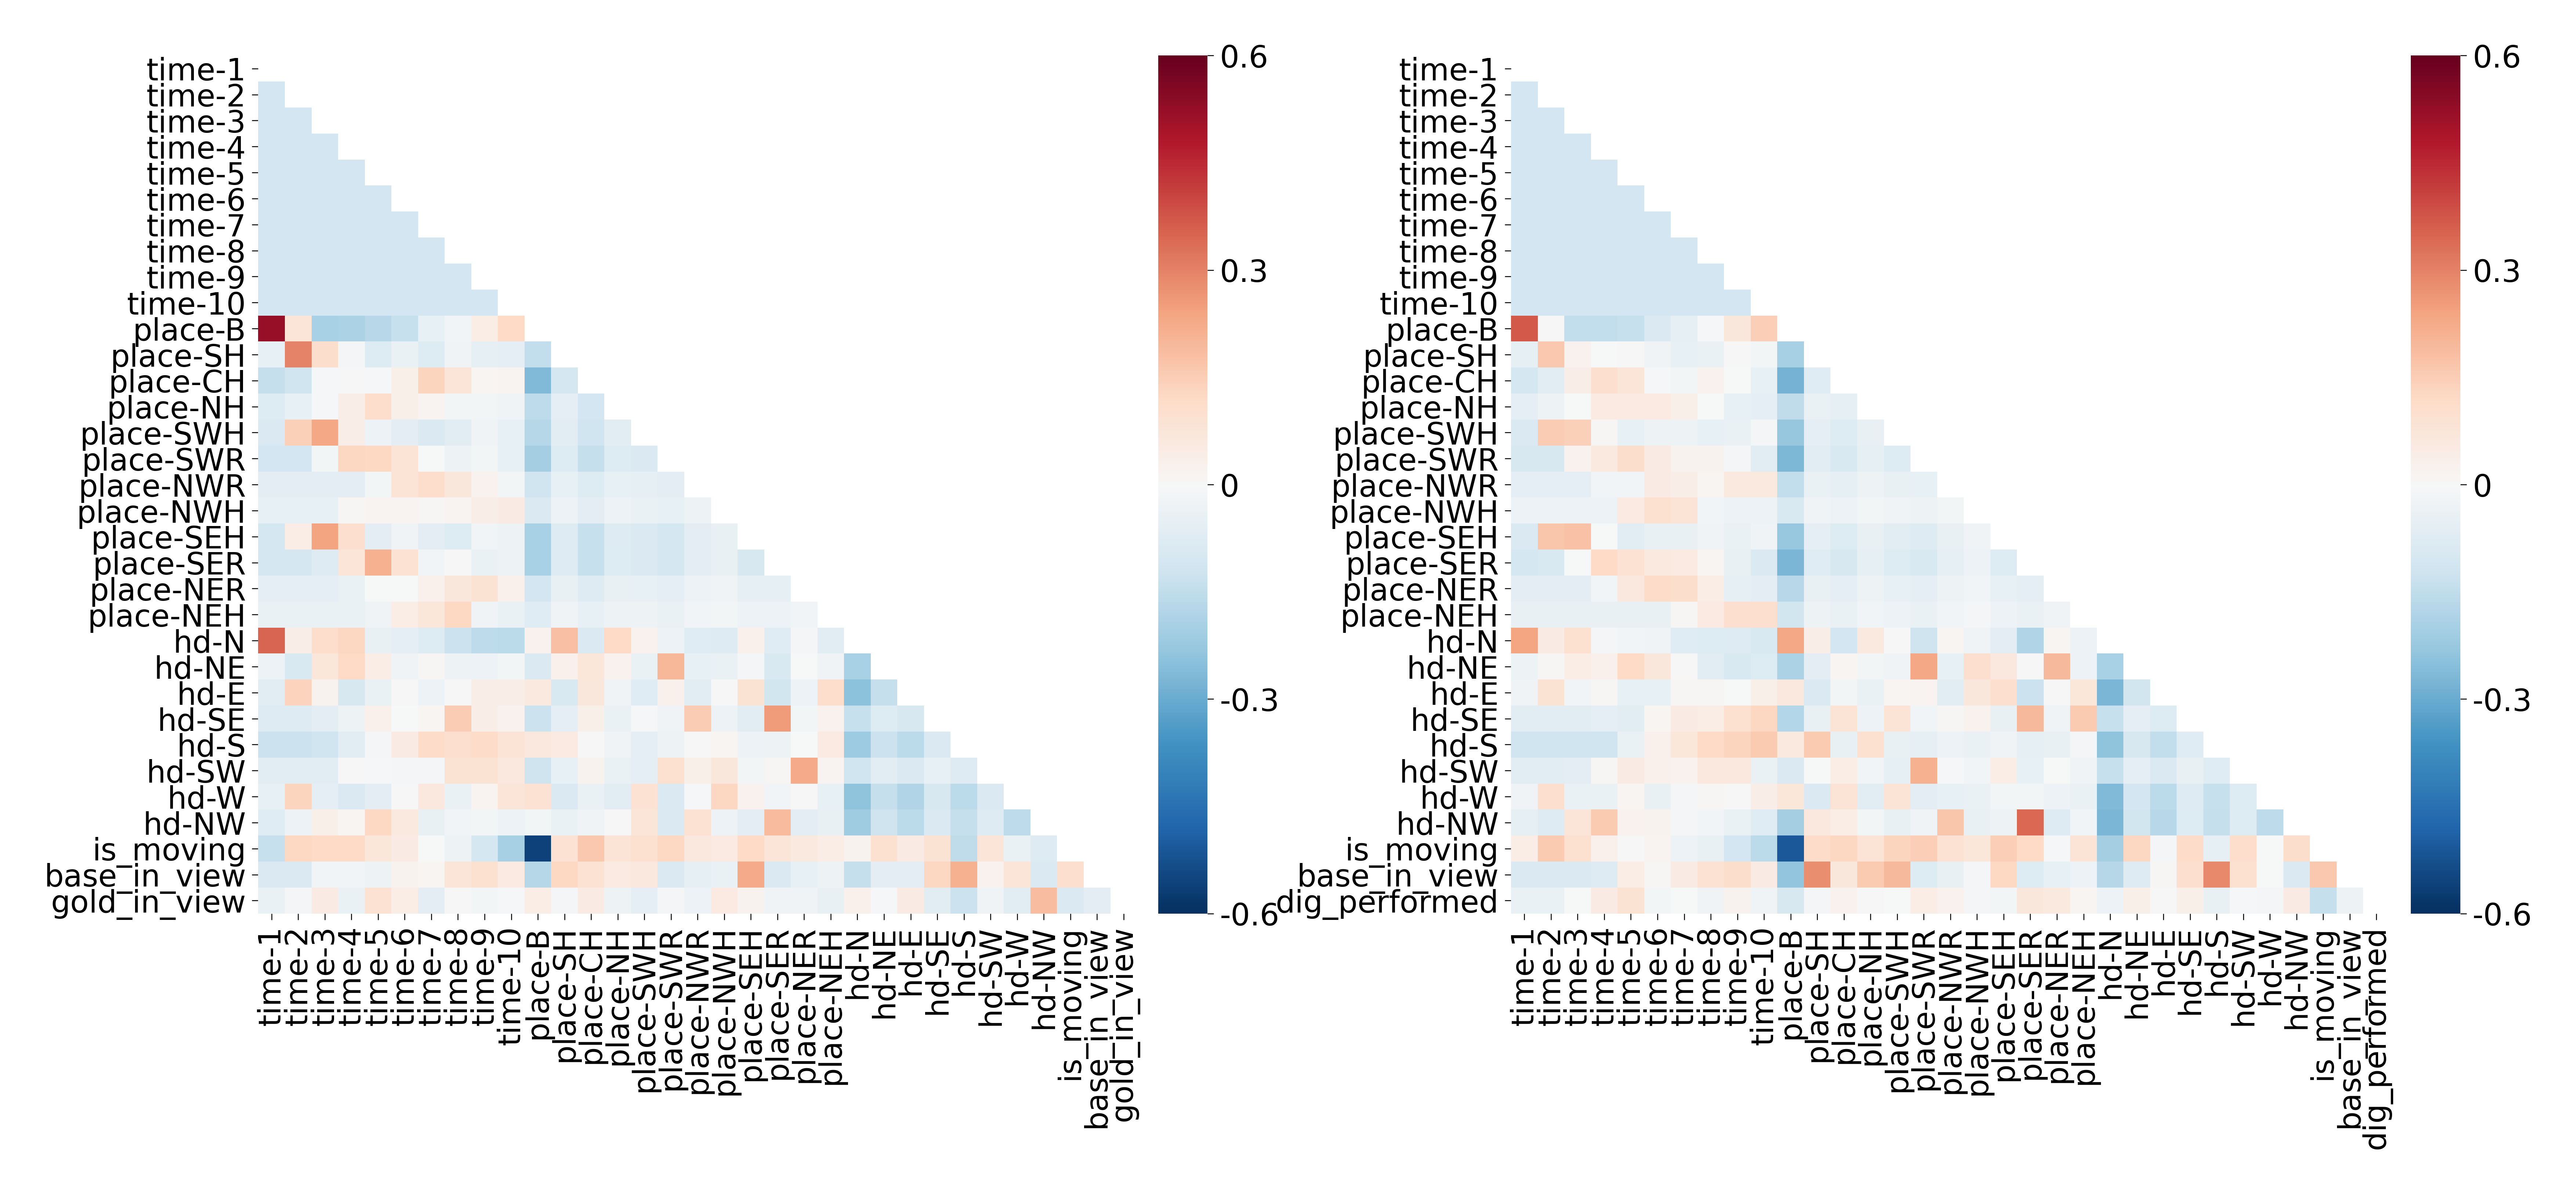

In [9]:
savefig = 0
overwrite = 0
game_states = ['Encoding', 'Retrieval']
colws = {1: 2.05, 2: 3.125, 3: 6.45}
grid_shp = (50, 125)
figsize = (colws[3], colws[3] * (grid_shp[0]/grid_shp[1]))
dpi = 1200
font = {'tick': 5, 'label': 6, 'fig': 7}
ticklength = 1
tickwidth = 0.15
tickpad = 1
labelpad = 1.5
cbar_label = None
cmap = 'RdBu_r'

vmax = np.round(np.max([np.nanmax(np.tril(np.abs(mean_corrs[game_state]), k=-1)) for game_state in game_states]), 1)
vmin = -vmax
print(vmin, vmax)

plt.close()
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = [plt.subplot2grid(grid_shp, (0, 0), rowspan=50, colspan=50),
      plt.subplot2grid(grid_shp, (0, 51), rowspan=50, colspan=3),
      plt.subplot2grid(grid_shp, (0, 71), rowspan=50, colspan=50),
      plt.subplot2grid(grid_shp, (0, 122), rowspan=50, colspan=3)]

for igs, game_state in enumerate(game_states):
    iax = 2 * igs
    keep_cols = mean_corrs[game_state].columns[np.where(np.all(np.isfinite(mean_corrs[game_state]), axis=0))[0]]
    corr_mat = mean_corrs[game_state][keep_cols]
    mask = np.zeros(corr_mat.shape)
    mask[np.triu_indices(corr_mat.shape[0], k=0)] = 1
    sns.heatmap(corr_mat, ax=ax[iax], cbar=True, cbar_ax=ax[iax+1],
                vmin=vmin, vmax=vmax, cmap=cmap, mask=mask)
    
    # Configure the colorbar.
    cbar = ax[iax].collections[0].colorbar
    cbar.ax.tick_params(labelsize=font['tick'], length=ticklength, width=tickwidth, pad=tickpad)
    cbar_ticks = np.linspace(vmin, vmax, 5)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['{:g}'.format(x) for x in np.round(cbar_ticks, 1)])
    if cbar_label is not None:
        cbar.set_label(cbar_label, fontsize=font['label'], labelpad=labelpad)

    # Tweak other plot params.
    ax[iax].tick_params(axis='both', which='both', length=ticklength, width=tickwidth, pad=tickpad)
    xticks = list(corr_mat.columns)
    yticks = list(corr_mat.index)
    ax[iax].set_xticks(np.arange(len(xticks)) + 0.5)
    ax[iax].set_xticklabels(xticks, fontsize=font['tick'])
    ax[iax].set_yticks(np.arange(len(yticks)) + 0.5)
    ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
    ax[iax].set_xlabel('')
    ax[iax].set_ylabel('')
    ax[iax].set_facecolor('w')

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_behav',
                       'behav_param_corr_matrix-Encoding_Retrieval-{}subjs.pdf'
                       .format(behav_corrs['subj'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [10]:
print('BAD TRIALS')
n_subjs = np.unique([subj_sess.split('_')[0] for subj_sess in sessions]).size
n_sess = len(sessions)
n_trials = 0
n_bad_trials = 0
for subj_sess in sessions:
    n_trials += len(events[subj_sess].trials)
    if events[subj_sess].bad_trials:
        n_bad_trials += len(events[subj_sess].bad_trials)
        print(subj_sess)
        for trial, trial_phases in events[subj_sess].bad_trial_phases:
            print('\t{}, {}'.format(trial, trial_phases))
            
print('Across {} subjects and {} sessions, we included {}/{} ({:.1%}) trials in the analysis.'.format(n_subjs,
                                                                                                      n_sess,
                                                                                                      n_trials - n_bad_trials,
                                                                                                      n_trials,
                                                                                                      (n_trials - n_bad_trials) / n_trials))

BAD TRIALS
Across 1 subjects and 1 sessions, we included 36/36 (100.0%) trials in the analysis.


In [11]:
game_states = ['Encoding', 'Retrieval']

pct_moving = {game_state: [] for game_state in game_states}
for subj_sess in events:
    _positions = events[subj_sess].positions
    moved = _positions.query("(gameState=={})".format(game_states)).groupby('gameState')['moved_pos'].mean()
    for game_state in game_states:
        pct_moving[game_state].append(moved[game_state])

In [12]:
print('Time spent moving', '-' * 17, sep='\n')
for game_state in game_states:
    print('{}: {:.1%} ± {:.1%}'.format(game_state, np.mean(pct_moving[game_state]), stats.sem(pct_moving[game_state])))

Time spent moving
-----------------
Encoding: 46.5% ± nan%
Retrieval: 30.0% ± nan%


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
idx = np.where(events['U540_ses0'].events['value'].apply(lambda x: "'scoreChange': 10," in str(x)))[0]
n_digs = events['U540_ses0'].events.query("(key=='dig')").shape[0]
gold_dug = events['U540_ses0'].events.iloc[idx].shape[0]

print('{}/{} ({:.1%})'.format(gold_dug, n_digs, gold_dug/n_digs))

18/31 (58.1%)


In [15]:
_events.dig_events['dig_success'].mean(), gold_dug / len(_events.dig_events)

NameError: name '_events' is not defined

In [16]:
subj_performance = pd.DataFrame([['U518': 25,
                                  'U521': 9,
                                  'U526': 32,
                                  'U527': 46,
                                  'U530': 15,
                                  'U532': 49,
                                  'U536': 32,
                                  'U537': 15,
                                  'U539': 12,
                                  'U540': 18]],
                                columns=['subj', 'gold_dug'])

SyntaxError: invalid syntax (<ipython-input-16-f976dd11d8bf>, line 1)

In [17]:
# How many golds were spawned, viewed, and dug in each session?
n_trials = []
gold_spawned = []
min_gold = []
max_gold = []
mean_gold = []
gold_viewed = []
gold_dug = []
dig_acc = []
for subj_sess in sessions:
#     _events = events[subj_sess]
    _events = events_proc.load_events(subj_sess, verbose=0)
    n_trials.append(_events.gold_spawned['trial'].unique().size)
    gold_spawned.append(_events.gold_spawned['gold_id'].unique().size)
    gold_per_trial = _events.gold_spawned.groupby('trial').size()
    min_gold.append(np.min(gold_per_trial))
    max_gold.append(np.max(gold_per_trial))
    mean_gold.append(np.mean(gold_per_trial))
    gold_viewed.append(_events.gold_events.query("(in_view==True)")['gold_id'].unique().size)
    gold_dug.append(len(_events.dig_events.query("(dig_success==True)")))
    dig_acc.append(_events.dig_events['dig_success'].mean())
    print('{}: {} trials {} gold spawned ({}-{}/trial, mean {:.1f}), {}/{} ({:.1%}) viewed, {:>2}/{} ({:.1%}) dug, {:.1%} digging accuracy'
          .format(subj_sess, n_trials[-1], gold_spawned[-1], min_gold[-1], max_gold[-1], mean_gold[-1],
                  gold_viewed[-1], gold_spawned[-1], gold_viewed[-1] / gold_spawned[-1],
                  gold_dug[-1], gold_viewed[-1], gold_dug[-1] / gold_viewed[-1], dig_acc[-1]))

print('', 'Across sessions', '-' * 15,
      'gold_spawned: mean = {:.1f} (range {}-{})'.format(np.mean(gold_spawned), np.min(gold_spawned), np.max(gold_spawned)),
      'gold_viewed: mean = {:.1f} (range {}-{})'.format(np.mean(gold_viewed), np.min(gold_viewed), np.max(gold_viewed)),
      'gold_dug: mean = {:.1f} (range {}-{})'.format(np.mean(gold_dug), np.min(gold_dug), np.max(gold_dug)),
      'dig_acc: mean = {:.1%} (range {:.1%}-{:.1%})'.format(np.mean(dig_acc), np.min(dig_acc), np.max(dig_acc)), sep='\n')

U540_ses0: 36 trials 48 gold spawned (1-3/trial, mean 1.3), 36/48 (75.0%) viewed, 18/36 (50.0%) dug, 58.1% digging accuracy

Across sessions
---------------
gold_spawned: mean = 48.0 (range 48-48)
gold_viewed: mean = 36.0 (range 36-36)
gold_dug: mean = 18.0 (range 18-18)
dig_acc: mean = 58.1% (range 58.1%-58.1%)


In [18]:
gold_viewed = np.array(gold_viewed)
gold_dug = np.array(gold_dug)

gold_viewed_ = np.concatenate(([gold_viewed[:2].mean()], gold_viewed[2:5], [gold_viewed[5:7].mean()], gold_viewed[7:]))
gold_dug_ = np.concatenate(([gold_dug[:2].mean()], gold_dug[2:5], [gold_dug[5:7].mean()], gold_dug[7:]))

print('{:.0%} ± {:.0%} (min={:.0%}, max={:.0%}) of viewed gold was dug (across subjects)'
      .format(np.mean(gold_dug_ / gold_viewed_),
              stats.sem(gold_dug_ / gold_viewed_),
              np.min(gold_dug_ / gold_viewed_),
              np.max(gold_dug_ / gold_viewed_)))

nan% ± nan% (min=nan%, max=nan%) of viewed gold was dug (across subjects)


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """


In [19]:
len(gold_dug)

1

In [20]:
sessions[5:7]

array([], dtype='<U9')

In [24]:
gold_dug[5:7].mean()

15.0

In [ ]:
# Ranking view performance: U521, U537, U530, U526, U518, U536, U532, U527
# Ranking dig performance: U521, U537, U530, U518, U536, U526, U527, U532

In [21]:
# For what percent of encoding/retrieval trials was the subject 
# already back at the base when 30 sec were up?
def get_back_at_base(_events):
    df = _events.events.query("(trial=={})".format(_events.keep_trials))
    rtb_inds = np.array(df.query("(key=='gameState')")[df.query("(key=='gameState')")['value'].apply(lambda x: x['stateName']=='ReturnToBase')].index)
    position_inds = np.array(df.query("(key=='playerTransform')").index)

    x = np.expand_dims(rtb_inds, 1) - position_inds # rtb x position
    x[x<0] = 1e6
    back_at_base = df.loc[position_inds[x.argmin(axis=1)]].reset_index(drop=True)
    back_at_base['at_base'] = back_at_base['value'].apply(lambda x: 1 * x['playerAtBase']).tolist()
    
    if 'subj_sess' not in back_at_base:
        back_at_base['subj_sess'] = _events.subj_sess
        
    cols = ['subj_sess', 'trial', 'gameState', 'time_penalty', 'at_base']
    return back_at_base[cols]
    
back_at_base = pd.concat([get_back_at_base(events[subj_sess]) for subj_sess in events], axis=0)
back_at_base = back_at_base.groupby(['subj_sess', 'gameState', 'time_penalty']).agg({'at_base': np.mean}).reset_index()
back_at_base['at_base'] *= 100  # conv to percent

In [11]:
#events[subj_sess].time_penalty

In [22]:
rtb_times = []
for subj_sess in sessions:
    subj, sess = subj_sess.split('_')
    for game_state in ['ReturnToBase1', 'ReturnToBase2']:
        for idx, row in events[subj_sess].event_times.query("(gameState=='{}')".format(game_state)).iterrows():
            rtb_times.append([subj_sess, subj, sess, row['trial'], events[subj_sess].time_penalty[row['trial']], game_state, row['duration']])
cols = ['subj_sess', 'subj', 'sess', 'trial', 'time_penalty', 'gameState', 'duration']
rtb_times = pd.DataFrame(rtb_times, columns=cols)

def _pctls(vec):
    pctls = [90, 95, 100]
    return list(zip(pctls, np.round(np.percentile(vec, [90, 95, 100]), 0).astype(int).tolist()))
    
rtb_times.groupby('gameState').agg({'duration': [np.mean, np.std, median_q, _pctls]})

duration                                        \
                      mean          std                 median_q   
gameState                                                          
ReturnToBase1  5984.555556  9493.793086  1192.00 (0.00, 8999.25)   
ReturnToBase2  2100.916667  4064.628631     0.00 (0.00, 2587.50)   

                                                         
                                                 _pctls  
gameState                                                
ReturnToBase1  [(90, 16850), (95, 26394), (100, 38365)]  
ReturnToBase2   [(90, 8750), (95, 10414), (100, 15800)]

In [57]:
# Number of trials with RTB > 0, 2, 5, 10s.
rtb_times.groupby(['subj_sess', 'gameState'])['duration'].apply(lambda x: '{:>2}  {:>2}  {:>2}  {:>2}'.format(np.sum(x>0), np.sum(x>2000), np.sum(x>5000), np.sum(x>10000)))

subj_sess  gameState    
U518_ses0  ReturnToBase1    21  18  13   7
           ReturnToBase2    19  17  10   4
U518_ses1  ReturnToBase1    22  18  11   1
           ReturnToBase2    16  14   9   2
U521_ses0  ReturnToBase1    25  24  23  14
           ReturnToBase2    29  29  27  21
U526_ses0  ReturnToBase1     8   4   3   2
           ReturnToBase2     3   2   0   0
U527_ses0  ReturnToBase1    17   8   4   2
           ReturnToBase2     6   5   3   0
U530_ses0  ReturnToBase1    11   9   6   6
           ReturnToBase2    13  11   9   8
U530_ses1  ReturnToBase1    15  11   7   2
           ReturnToBase2    22  16  12   4
U532_ses0  ReturnToBase1    12   8   4   2
           ReturnToBase2     6   3   3   1
U536_ses0  ReturnToBase1    21  21  18   9
           ReturnToBase2    17  15  11   4
U537_ses0  ReturnToBase1    21  19  14   7
           ReturnToBase2    23  20  16  11
Name: duration, dtype: object

In [23]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=1200)
ax = np.ravel(ax)

iax = 0
for game_state in rtb_times['gameState'].unique():
    _df = rtb_times.query("(gameState=='{}')".format(game_state)).copy()
    _df['duration'] *= 1e-3
    sns.lineplot(x='trial', y='duration', hue='subj_sess', data=_df, ax=ax[iax])
    ax[iax].get_legend().remove()
    ax[iax].set_xlabel('Trial')
    ax[iax].set_ylabel('Duration')
    iax += 1
    
fig.tight_layout()
fig.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


In [24]:
# For each subject, figure out how many traversals are in each direction.
cols = ['subj_sess', 'hd', 'n']
game_states = ['Encoding', 'Retrieval']
hd_df = []
for subj_sess in events:
    for hd in ['N', 'S', 'E', 'W']:
        hd_df.append([subj_sess, hd, events[subj_sess].pos_intervals.query("(gameState=={}) & (head_direc=='{}')".format(game_states, hd))['dur'].sum()])
hd_df = pd.DataFrame(hd_df, columns=cols)

# For each session, convert no. traversals to pct. traversals.
for idx, df in hd_df.groupby('subj_sess'):
    hd_df.loc[df.index, 'n'] = 100 * (df['n'] / df['n'].sum())

AttributeError: 'Events' object has no attribute 'pos_intervals'

In [25]:
display(hd_df.groupby('hd').agg({'n': lambda x: '{:.1f} $\pm$ {:.1f}'.format(np.mean(x), stats.sem(x))}))

model = ols('n ~ C(hd)', hd_df).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<input>:1: DeprecationWarning: invalid escape sequence \p
<ipython-input-25-98feedf3f960>:1: DeprecationWarning: invalid escape sequence \p
  display(hd_df.groupby('hd').agg({'n': lambda x

AttributeError: 'list' object has no attribute 'groupby'

In [26]:
game_states = ['Encoding', 'Retrieval']
scaling_factor = 1

traversals = {}
n_sess = 0
for subj_sess in events:
    if events[subj_sess].maze.maze_name != 'SMaze2':
        continue
    _d = (events[subj_sess].pos_intervals
                           .query("(gameState=={})".format(game_states))['maze_idx']
    #                        .apply(lambda x: (np.int(x[0]*scaling_factor), np.int(x[1]*scaling_factor)))
                           .value_counts().to_dict())
    
    # Sum traversals across sessions.
    for k, v in _d.items():
        if k in traversals:
            traversals[k] += v
        else:
            traversals[k] = v
    n_sess += 1
    
for k in traversals:
    traversals[k] /= n_sess

AttributeError: 'Events' object has no attribute 'pos_intervals'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


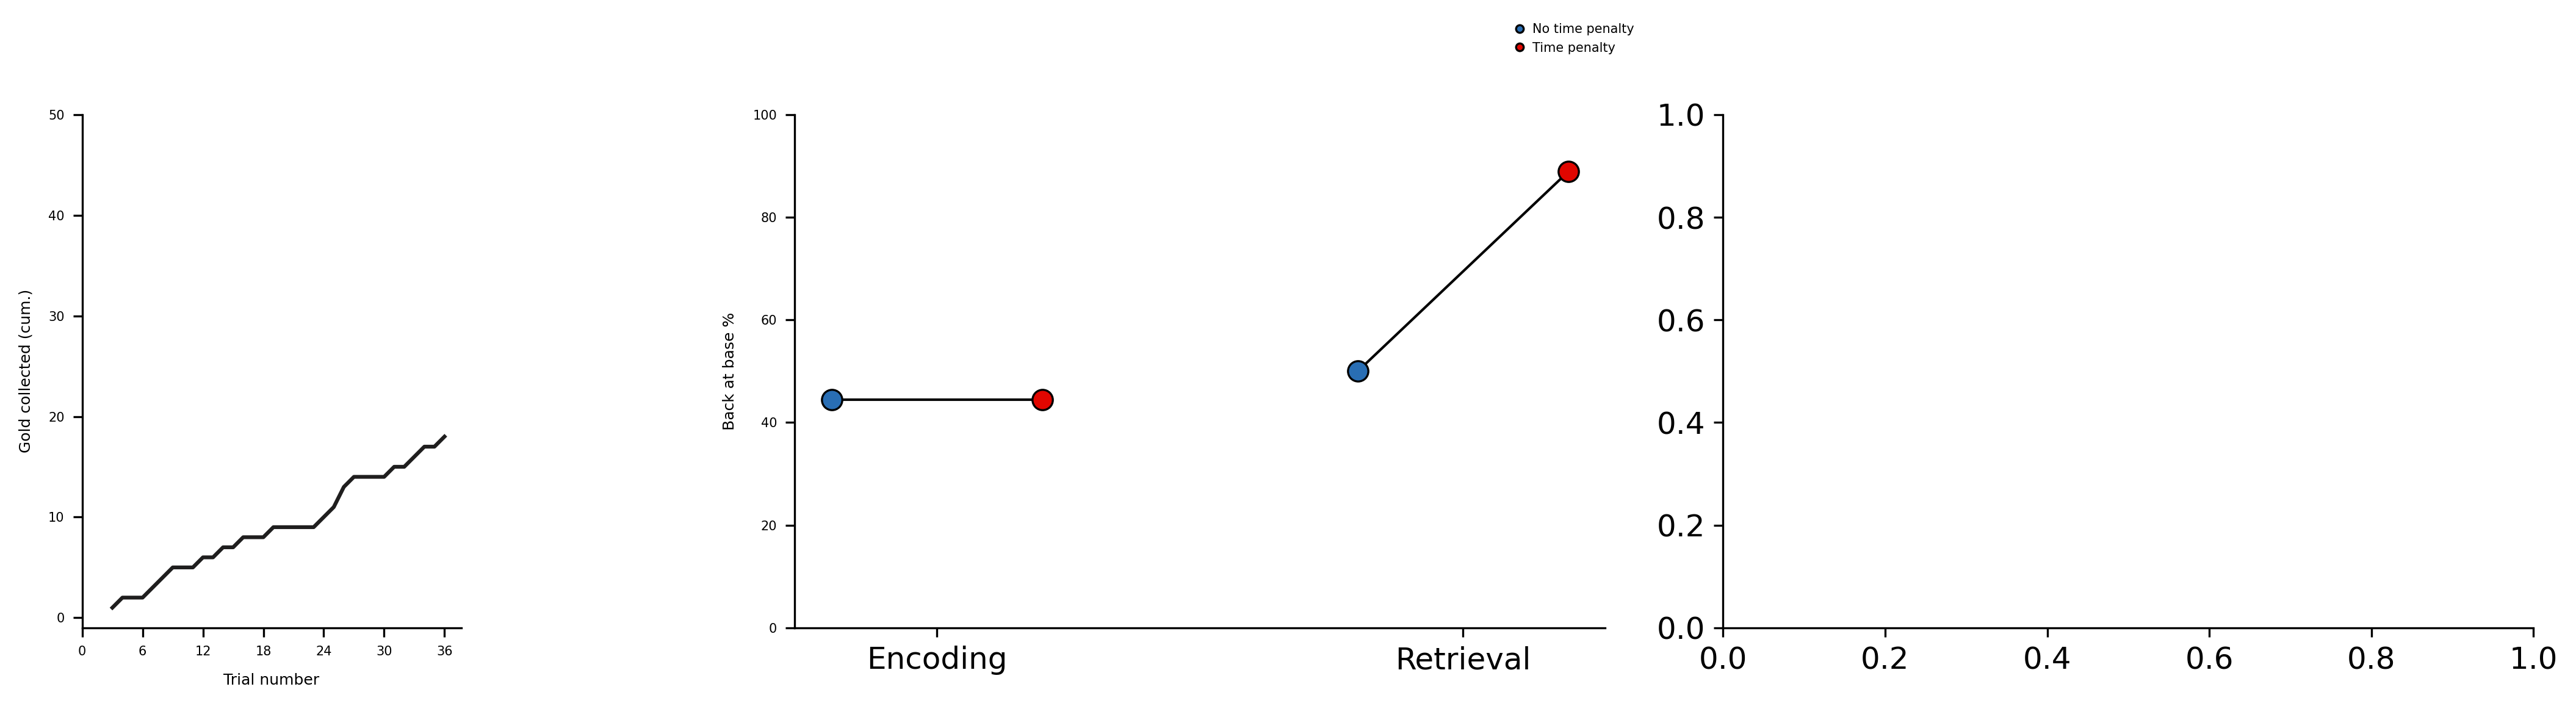

In [27]:
# Plot behavior.
warnings.filterwarnings('ignore')
plt.close()
fig, ax = plt.subplots(1, 3, figsize=(15, 4), dpi=300)
ax = np.ravel(ax)
_colors = ['#296eb4', '#e10600', '#f3a5bf', '#bebebe'] # blue, red, pink, gray

# Plot gold dug by trial.
i = 0
#_cmap = sns.color_palette('Spectral', len(sessions))
_cmap = sns.color_palette('icefire', len(sessions))
# _cmap = sns.color_palette('Paired')
# _cmap = np.array(_cmap)[[0, 1, 2, 4, 6, 8, 9, 10, 11, 12], :]
# _cmap = sns.color_palette(_cmap)
# _cmap[-2] = '#bebebe'
for iLine, subj_sess in enumerate(np.sort(sessions)):
    _events = events[subj_sess]
    n_trials = np.max(_events.trials)
    gold_by_trial = []
    for trial in range(1, n_trials+1):
        gold_by_trial.append([trial, _events.dig_events.query("(dig_success==True)").groupby('trial').size().cumsum().get(trial, np.nan)])
    gold_by_trial = pd.DataFrame(gold_by_trial, columns=['trial', 'gold_dug'])
    gold_by_trial['gold_dug'] = gold_by_trial['gold_dug'].fillna(method='ffill')
    ax[i].plot(gold_by_trial['trial'], gold_by_trial['gold_dug'], linewidth=1.5, color=_cmap[iLine])
    
ax[i].set_xticks(np.arange(0, 37, 6, dtype=np.int))
ax[i].set_xticklabels(np.arange(0, 37, 6, dtype=np.int), 
                      fontsize=font['tick'])
ax[i].set_ylim([-1, 50])
ax[i].set_yticks(np.arange(0, 51, 10, dtype=np.int))
ax[i].set_yticklabels(np.arange(0, 51, 10, dtype=np.int), fontsize=font['tick'])
ax[i].set_xlabel('Trial number', fontsize=font['label'], labelpad=6)
ax[i].set_ylabel('Gold collected (cum.)', fontsize=font['label'], labelpad=6)
ax[i].set_aspect('equal')

# Plot return-to-base percentage.
i = 1
ax[i] = sns.stripplot('gameState', 'at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                      hue_order=[0, 1], jitter=False, dodge=True, palette=_colors, size=8, linewidth=0.8, edgecolor='k')
for ii, game_state in enumerate(['Encoding', 'Retrieval']):
    yvals = [back_at_base.query("(gameState=='{}') & (time_penalty==0)".format(game_state)).sort_values('subj_sess')['at_base'].tolist(),
             back_at_base.query("(gameState=='{}') & (time_penalty==1)".format(game_state)).sort_values('subj_sess')['at_base'].tolist()]
    for iPoint in range(len(yvals[0])):
        ax[i].plot((ii - 0.2, ii + 0.2), (yvals[0][iPoint], yvals[1][iPoint]), 
                   color='k', linewidth=1, zorder=0)
yax = np.arange(0, 101, 20, dtype=np.int)
ax[i].set_yticks(yax)
ax[i].set_yticklabels(yax, fontsize=font['tick'])
ax[i].set_xlabel('')
ax[i].set_ylabel('Back at base %', fontsize=font['label'], labelpad=6)
custom_lines = [Line2D([0], [0], lw=0, marker='o', color='k', label='No time penalty', markerfacecolor=_colors[0], markeredgewidth=0.8, markersize=font['tick']-2),
                Line2D([0], [0], lw=0, marker='o', color='k', label='Time penalty', markerfacecolor=_colors[1], markeredgewidth=0.8, markersize=font['tick']-2)]
legend = ax[i].legend(handles=custom_lines, fontsize=font['tick'], loc=1, bbox_to_anchor=(1.05, 1.2), handletextpad=0)

i = 2
# Plot time spent in each maze location.
# ax[i], maze_map, mask = draw_maze_precise(goldmine_behavior.Maze('SMaze2'),
#                                           traversals,
#                                           scaling_factor=scaling_factor,
#                                           do_convolve=False,
#                                           show_nav=False,
#                                           draw_base=True,
#                                           square=True,
#                                           cmap='rocket',
#                                           cbar_label='No. traversals',
#                                           ax=ax[i])
# ax[i], maze_map, mask = draw_maze(goldmine_behavior.Maze('SMaze2'),
#                                   traversals,
#                                   vmin=0,
#                                   vmax=80,
#                                   draw_base=True,
#                                   square=True,
#                                   cmap='viridis',
#                                   facecolor='#cbced3',
#                                   color_base=colors[1],
#                                   lw_base=1.6,
#                                   cbar_label='No. traversals',
#                                   ax=ax[i])
# cbar = ax[i].collections[0].colorbar
# cbar.ax.tick_params(labelsize=font['tick'])
# cbar_ticks = np.arange(0, 81, 20)
# cbar.set_ticks(cbar_ticks)
# cbar.set_ticklabels(cbar_ticks)
# cbar.set_label('Mean traversals', fontsize=font['annot'], labelpad=6)

fig.tight_layout()
fig.show()
warnings.resetwarnings()

In [83]:
bab = pd.pivot(back_at_base, ['subj_sess', 'gameState'], 'time_penalty', 'at_base').reset_index()
for game_state in ['Encoding', 'Retrieval']:
    _bab = bab.loc[bab['gameState']==game_state]
    print(game_state)
    print('time penalty   : {:.1f} ± {:.1f}%'.format(np.mean(_bab[1]), stats.sem(_bab[1])))
    print('no time penalty: {:.1f} ± {:.1f}%'.format(np.mean(_bab[0]), stats.sem(_bab[0])))
    print(stats.ttest_rel(_bab[1], _bab[0]), 'df = {}'.format(len(_bab)-1), sep='\n', end='\n\n')

Encoding
time penalty   : 57.6 ± 6.8%
no time penalty: 43.9 ± 5.4%
Ttest_relResult(statistic=1.9195509740338925, pvalue=0.0871191334760324)
df = 9

Retrieval
time penalty   : 62.7 ± 7.3%
no time penalty: 49.8 ± 9.0%
Ttest_relResult(statistic=2.0155940901777187, pvalue=0.07465107857268233)
df = 9



In [29]:
digacc = []
for subj_sess in sessions:
    _, df = events[subj_sess].plot_digging_accuracy(ax=ax[i])
    digacc.append(df)
digacc = np.array(digacc)
digacc[digacc<0] = np.nan
plt.close()

AttributeError: 'Events' object has no attribute 'plot_digging_accuracy'

In [45]:
np.nanmean(digacc, axis=1), np.nanmean(digacc)

(array([46.66666667, 63.0952381 , 48.95833333, 79.88505747, 74.95238095,
        62.5       , 54.83870968]), 63.18100358422939)

# Gold find

AttributeError: 'collections.OrderedDict' object has no attribute 'plot_golds_dug'

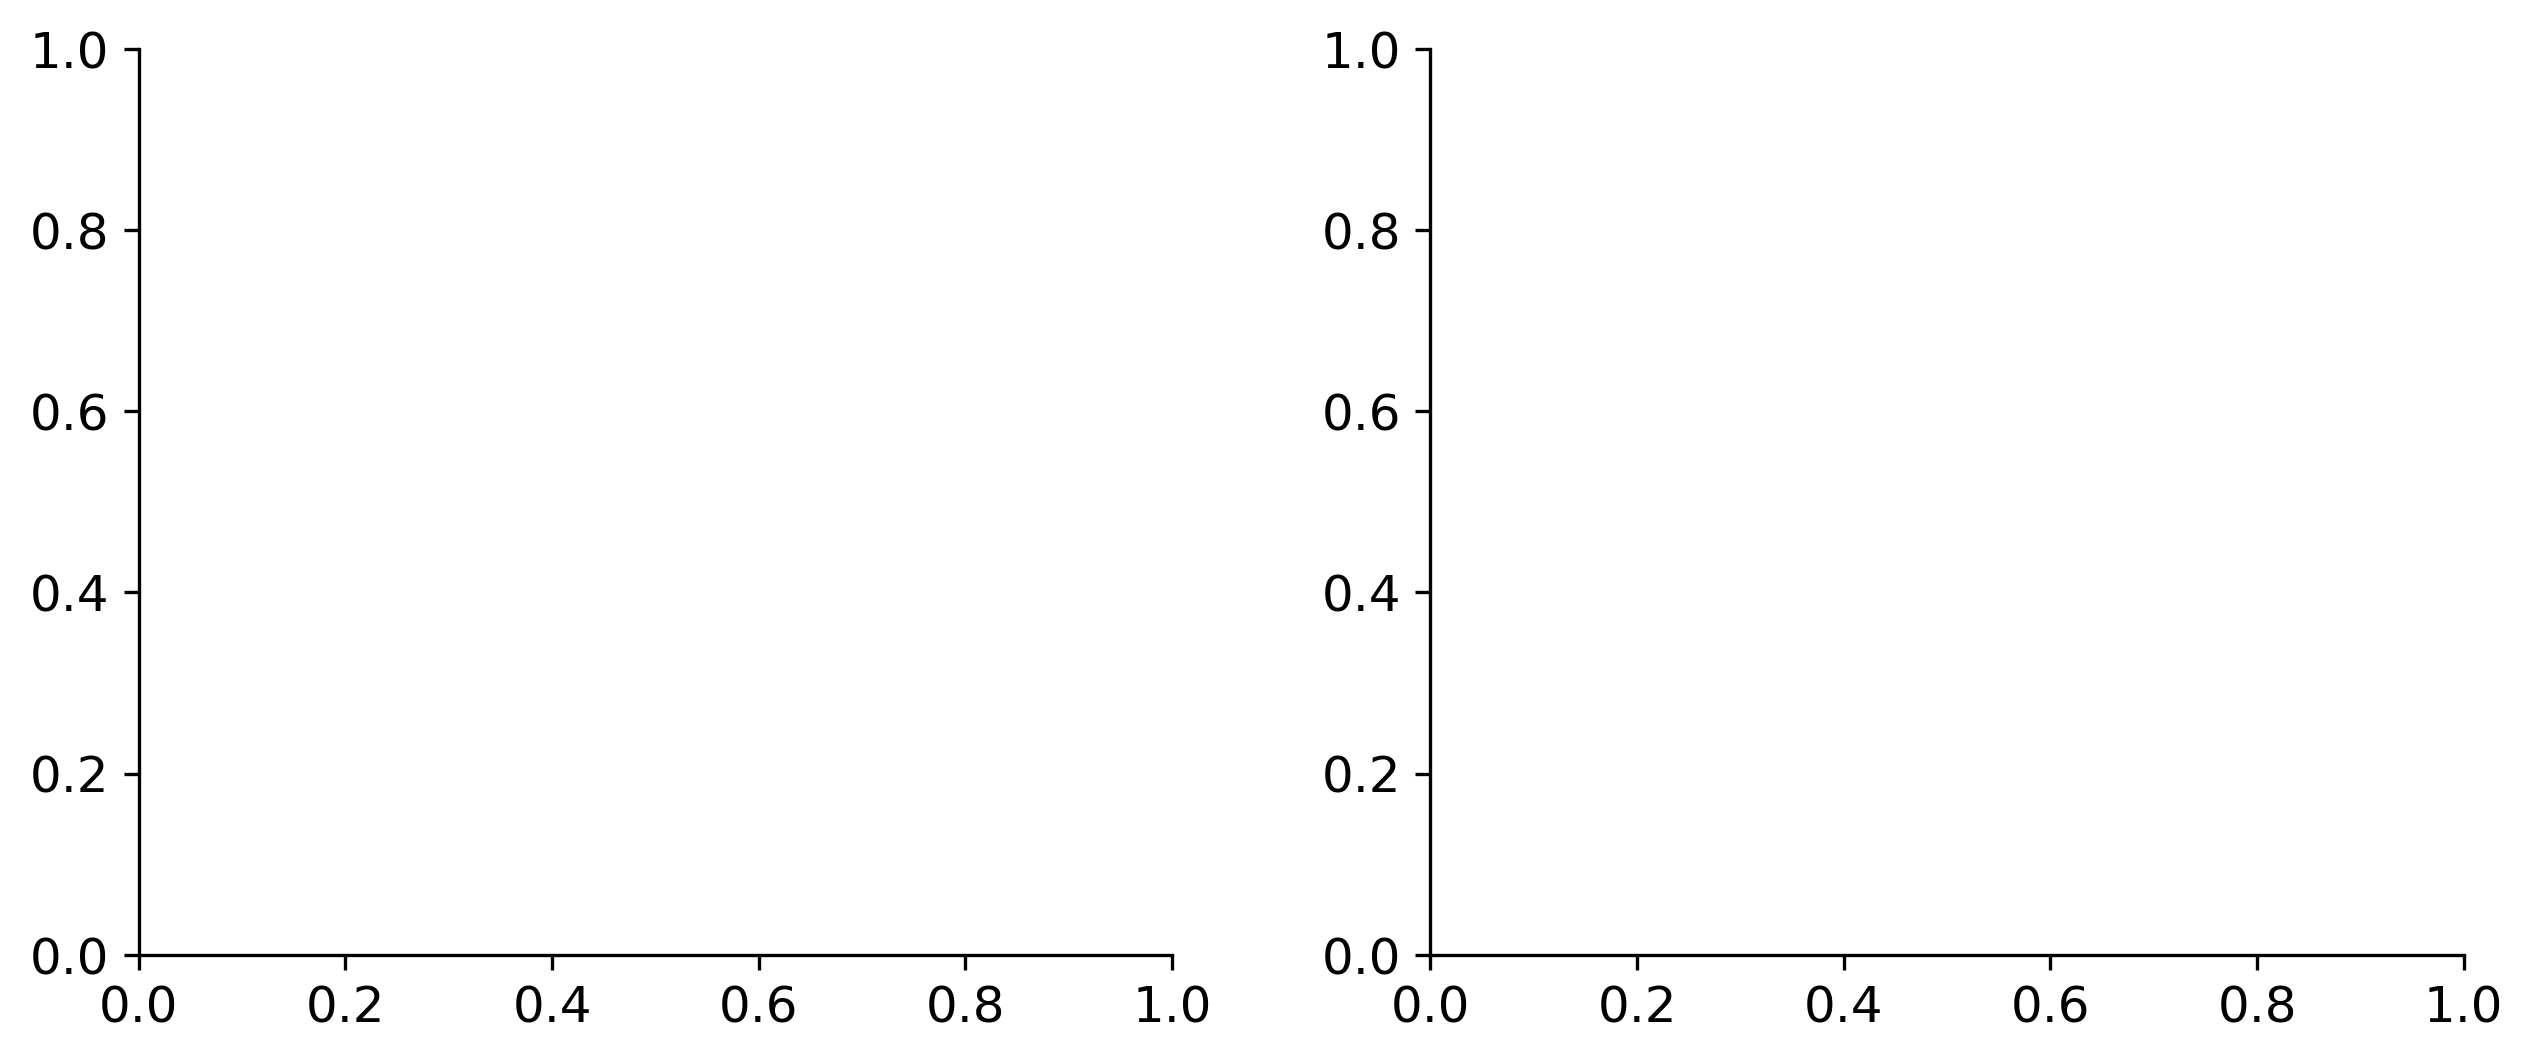

In [30]:
# Plot gold dug and digging accuracy across trials.
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i], _ = events.plot_golds_dug(ax=ax[i], savefig=False)

i = 1
ax[i], _ = events.plot_digging_accuracy(ax=ax[i], savefig=False)

fig.tight_layout(w_pad=2)

In [31]:
# What percent of golds were dug by trial?
cols = ['trial', 'time_penalty', 'gold_spawned', 'gold_dug', 'pct_dug']
digging = []
for idx, df in events.events.groupby('trial'):
    trial = idx
    gold_spawned = df.query("(key=='goldSpawned')")['value'].apply(lambda x: x['nItems']).tolist()[0]
    gold_dug = len(df.query("(key=='dig')")[df.query("(key=='dig')")['value'].apply(lambda x: x['successful'])])
    digging.append([trial, df.iloc[0]['time_penalty'], gold_spawned, gold_dug, (100 * gold_dug)/gold_spawned])
    
digging = pd.DataFrame(digging, columns=cols)  

AttributeError: 'collections.OrderedDict' object has no attribute 'events'

In [32]:
# How much distance is traveled, and much time spent moving vs. standing still?
cols = ['trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
travel = []
for idx, df in events.events.query("(key=='playerTransform') & (gameState==['Encoding', 'Retrieval'])").groupby(['trial', 'gameState']):
    trial, gameState = idx
    pos = np.array(df['value'].apply(lambda x: (x['positionX'], x['positionZ'])).tolist())
    dist_trav = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    travel.append([trial, gameState, df.iloc[0]['time_penalty'], np.sum(dist_trav), 100 * np.mean(dist_trav>0)])
    
travel = pd.DataFrame(travel, columns=cols)

AttributeError: 'collections.OrderedDict' object has no attribute 'events'

In [33]:
back_at_base = pd.concat([get_back_at_base(events[subj_sess]) for subj_sess in sessions], axis=0)

In [34]:
['U518_ses0-Encoding',
 'U518_ses0-Retrieval',
 'U521_ses0-Encoding',
 'U521_ses0-Retrieval',
 'U526_ses0-Encoding',
 'U526_ses0-Retrieval',
 'U527_ses0-Encoding',
 'U530_ses0-Encoding',
 'U530_ses0-Retrieval']

['U518_ses0-Encoding',
 'U518_ses0-Retrieval',
 'U521_ses0-Encoding',
 'U521_ses0-Retrieval',
 'U526_ses0-Encoding',
 'U526_ses0-Retrieval',
 'U527_ses0-Encoding',
 'U530_ses0-Encoding',
 'U530_ses0-Retrieval']

In [35]:
print(stats.ttest_ind(back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Encoding') & (time_penalty==1)")['at_base'].tolist(),
                      back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Encoding') & (time_penalty==0)")['at_base'].tolist()))
print(stats.ttest_ind(back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Retrieval') & (time_penalty==1)")['at_base'].tolist(),
                      back_at_base.query("(subj_sess=='U527_ses0') & (gameState=='Retrieval') & (time_penalty==0)")['at_base'].tolist()))

Ttest_indResult(statistic=nan, pvalue=nan)
Ttest_indResult(statistic=nan, pvalue=nan)


In [36]:
grp = back_at_base.groupby('subj_sess')
for subj_sess, back_at_base_ in grp:
    print(subj_sess, '\n')
    for game_state in ['Encoding', 'Retrieval']:
        print('{}: {:.2f}'.format(game_state,
                                  back_at_base_.query("(gameState=='{}') & (time_penalty==1)".format(game_state))['at_base'].mean() - 
                                  back_at_base_.query("(gameState=='{}') & (time_penalty==0)".format(game_state))['at_base'].mean()))
    print('\n')
    
    mod = ols('at_base ~ C(gameState) * C(time_penalty)', back_at_base_).fit()
    print(mod.summary())
    #print(mod.get_margeff().summary())
    
    print('\n')
    
    mod = ols('at_base ~ C(gameState) + C(time_penalty)', back_at_base_).fit()
    print(mod.summary())
    #print(mod.get_margeff().summary())

    print('\n\n\n')

U540_ses0 

Encoding: 0.00
Retrieval: 0.39


                            OLS Regression Results                            
Dep. Variable:                at_base   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3.716
Date:                Thu, 09 Feb 2023   Prob (F-statistic):             0.0155
Time:                        14:07:46   Log-Likelihood:                -46.091
No. Observations:                  72   AIC:                             100.2
Df Residuals:                      68   BIC:                             109.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [37]:
model = ols('at_base ~ C(gameState) * C(time_penalty)', back_at_base_).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

print('Minus the interaction\n---------------------')
model = ols('at_base ~ C(gameState) + C(time_penalty)', back_at_base_).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

Overall model F(3,68) = 3.72, p = 0.0155

                                 sum_sq    df         F    PR(>F)
C(gameState)                   1.125000   1.0  5.043956  0.027965
C(time_penalty)                0.680556   1.0  3.051282  0.085189
C(gameState):C(time_penalty)   0.680556   1.0  3.051282  0.085189
Residual                      15.166667  68.0       NaN       NaN

Minus the interaction
---------------------
Overall model F(2,69) = 3.93, p = 0.0242

                    sum_sq    df         F    PR(>F)
C(gameState)      1.125000   1.0  4.898335  0.030192
C(time_penalty)   0.680556   1.0  2.963190  0.089661
Residual         15.847222  69.0       NaN       NaN



In [38]:
stats.ttest_ind(digging.query("(time_penalty==1)")['pct_dug'],
                digging.query("(time_penalty==0)")['pct_dug'])

AttributeError: 'list' object has no attribute 'query'

In [39]:
model = ols('dist_trav ~ C(gameState) * C(time_penalty)', travel).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

print('Minus the interaction\n---------------------')

model = ols('dist_trav ~ C(gameState) + C(time_penalty)', travel).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

PatsyError: Error evaluating factor: TypeError: list indices must be integers or slices, not str
    dist_trav ~ C(gameState) * C(time_penalty)
                ^^^^^^^^^^^^

AttributeError: 'collections.OrderedDict' object has no attribute 'plot_params'

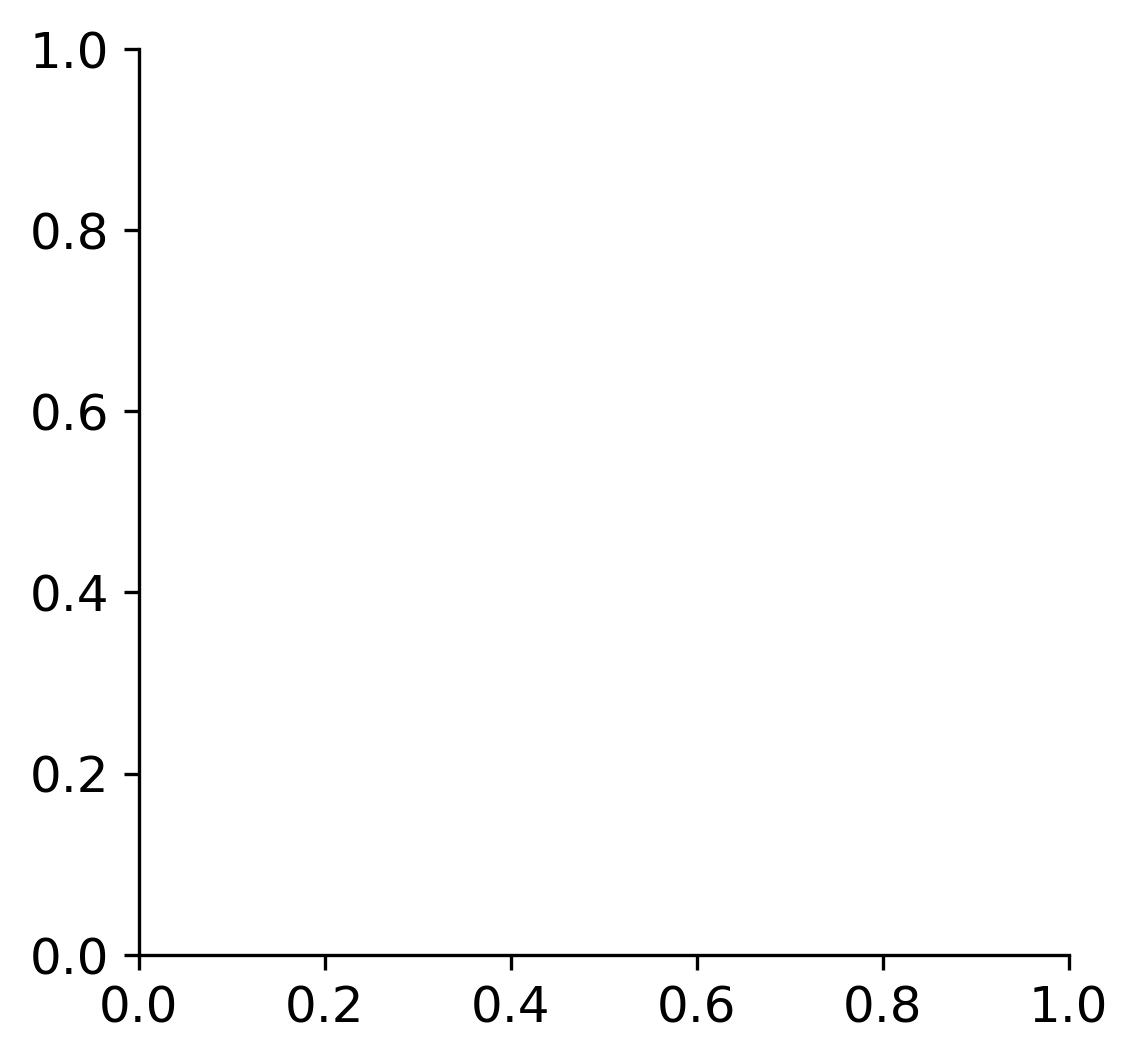

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2
font = events.plot_params['font']

i = 0
ax[i] = sns.barplot(x='gameState', y='at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 100])
ax[i].set_yticks(np.linspace(0, 100, 6))
ax[i].set_yticklabels(np.linspace(0, 100, 6, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Back at base (%)', fontsize=font['label'], labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick']),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.95))

fig.tight_layout()

if True:
    fig.savefig('/home1/cjmac/projects/time_cells/figs/{}-behavior-back_at_base.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

AttributeError: 'list' object has no attribute 'get'

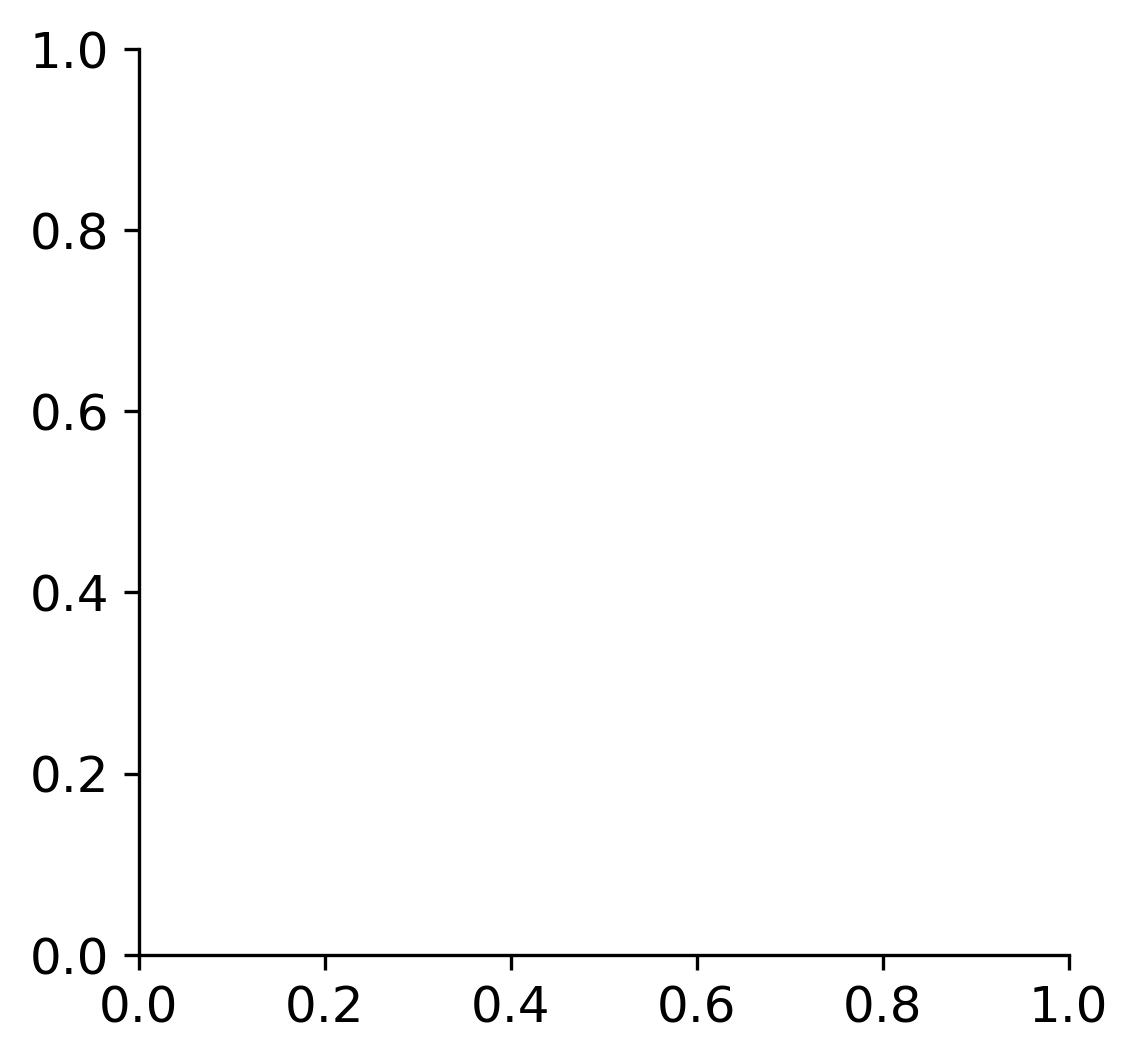

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='gameState', y='dist_trav', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Distance traveled (m)', fontsize=font['label'], labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick']),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.86))

fig.tight_layout()

if True:
    fig.savefig('/home1/cjmac/projects/time_cells/figs/{}-behavior-distance_traveled.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

AttributeError: 'list' object has no attribute 'get'

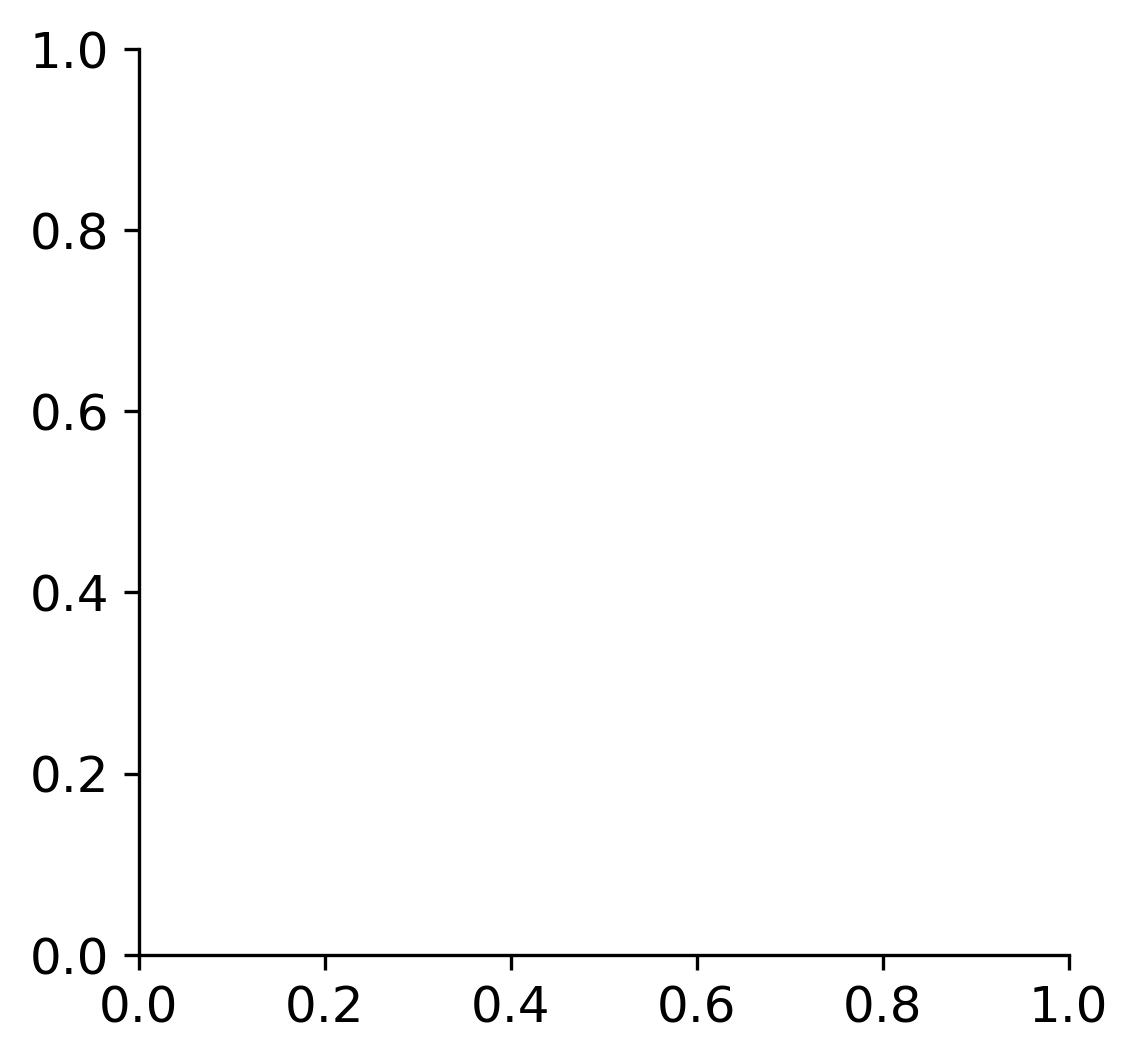

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='gameState', y='pct_moving', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time spent moving (%)', fontsize=font['label'], labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick']),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'])]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.86))

fig.tight_layout()

if True:
    fig.savefig('/home1/cjmac/projects/time_cells/figs/{}-behavior-time_moving.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

AttributeError: 'list' object has no attribute 'get'

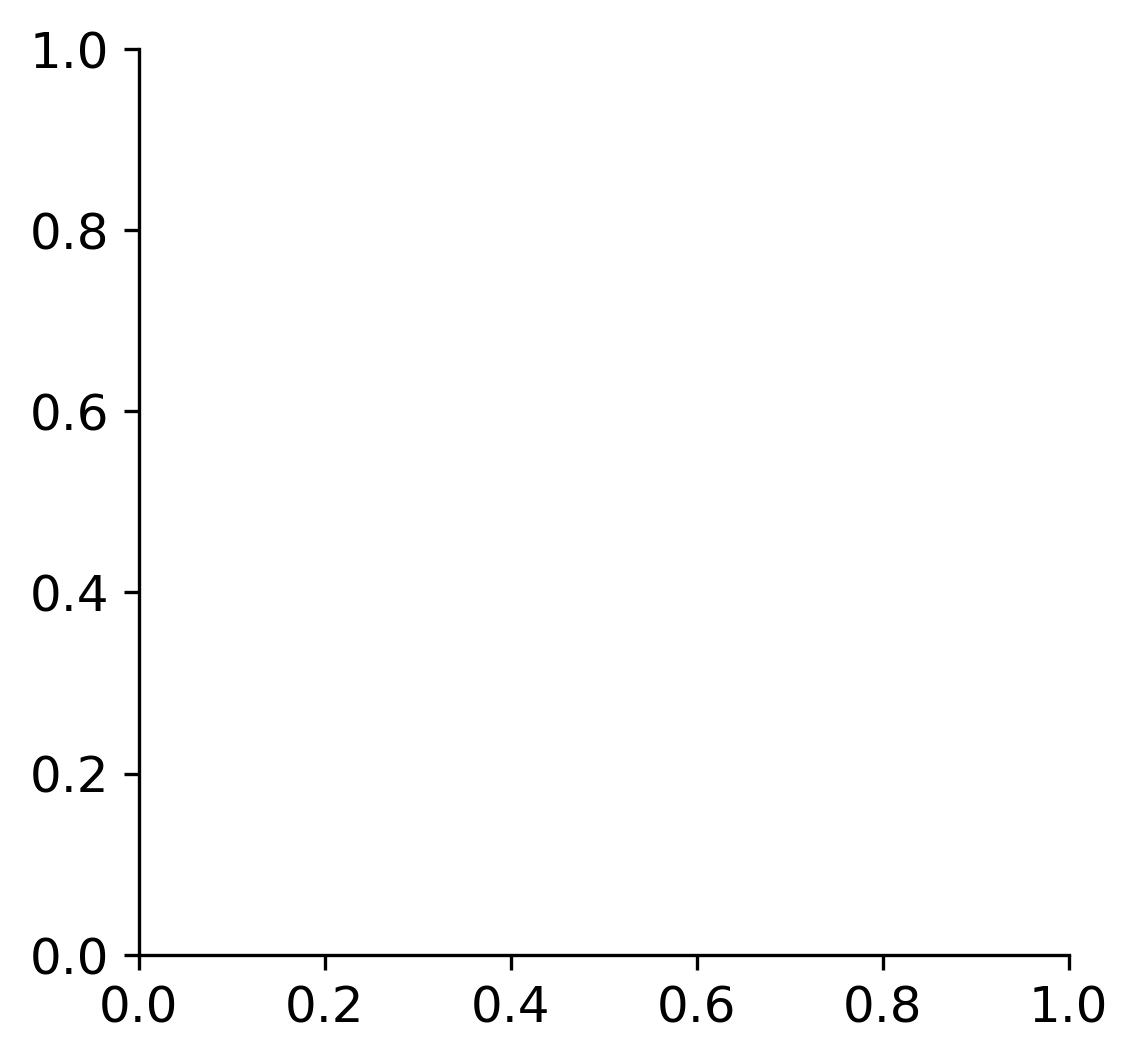

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='time_penalty', y='pct_dug', data=digging, ax=ax[i],
                    ci=None, color=colors[6], saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['No time penalty', 'Time penalty'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Gold dug (%)', fontsize=font['label'], labelpad=8)

fig.tight_layout()

if True:
    fig.savefig('/home1/cjmac/projects/time_cells/figs/{}-behavior-gold_dug.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

AttributeError: 'list' object has no attribute 'get'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


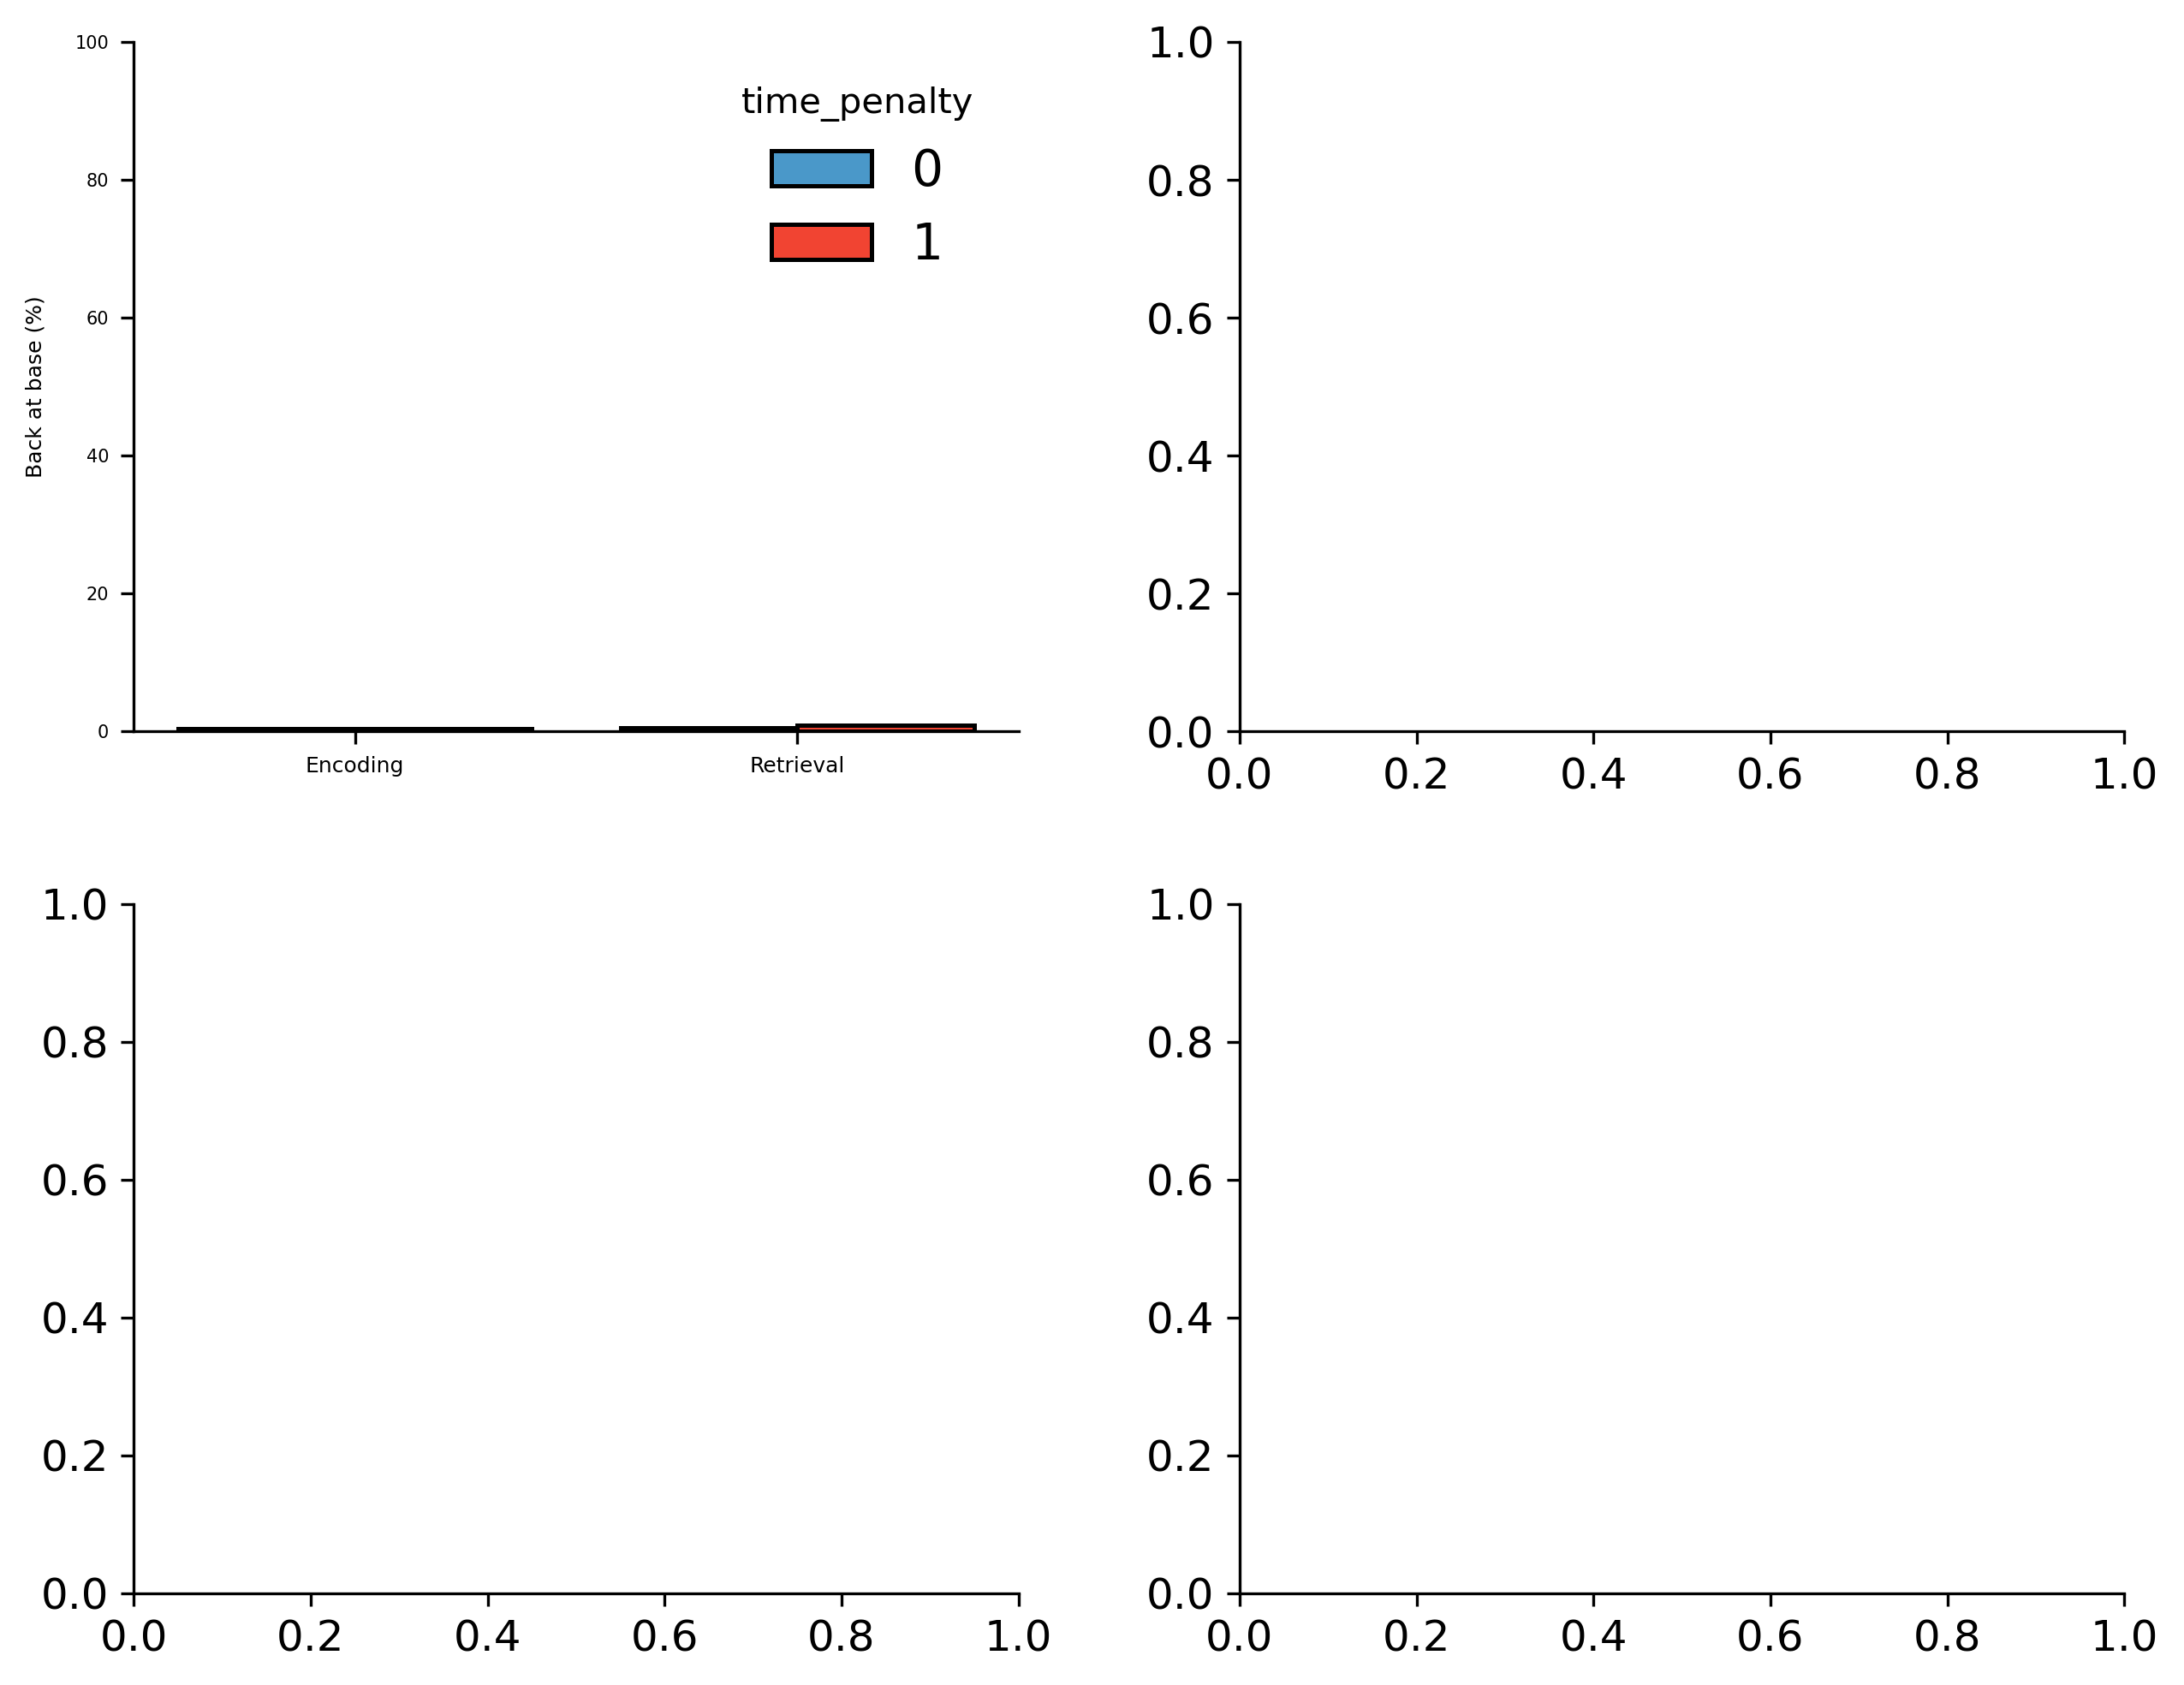

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
ax = np.ravel(ax)

bar_linewidth = 1.2

i = 0
ax[i] = sns.barplot(x='gameState', y='at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 100])
ax[i].set_yticks(np.linspace(0, 100, 6))
ax[i].set_yticklabels(np.linspace(0, 100, 6, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Back at base (%)', fontsize=font['label'], labelpad=8)

i = 1
ax[i] = sns.barplot(x='time_penalty', y='pct_dug', data=digging, ax=ax[i],
                    ci=None, color=colors[6], saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['No time penalty', 'Time penalty'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Gold dug (%)', fontsize=font['label'], labelpad=8)

i = 2
ax[i] = sns.barplot(x='gameState', y='dist_trav', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Distance traveled (m)', fontsize=font['label'], labelpad=8)
ax[i].get_legend().remove()

i = 3
ax[i] = sns.barplot(x='gameState', y='pct_moving', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1, linewidth=bar_linewidth, edgecolor='k')
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=font['label'])
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=font['tick'])
ax[i].set_xlabel('', fontsize=font['label'], labelpad=8)
ax[i].set_ylabel('Time spent moving (%)', fontsize=font['label'], labelpad=8)
ax[i].get_legend().remove()

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=font['tick'], linewidth=0.6, markeredgecolor='k'),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=font['tick'], linewidth=0.6, markeredgecolor='k')]
legend = ax[0].legend(handles=custom_lines, fontsize=font['tick'], loc=(0.5, 0.95))

fig.tight_layout()

if False:
    fig.savefig('/home1/cjmac/projects/time_cells/figs/{}_behav2.png'.format(subj_sess), 
                format='png', dpi=300, bbox_inches='tight')

# Subject location and movement

In [45]:
# Calculate the duration (s) between consecutive position measurements.
pos_dur = np.median(events.positions.groupby(['trial', 'gameState'])['time'].apply(lambda x: np.median(np.diff(x)))) * 1e-3

# How much time did the player spend at each location?
counts = (events.positions['maze_idx'].value_counts() * pos_dur).to_dict()

maze_vals = counts.copy()

AttributeError: 'collections.OrderedDict' object has no attribute 'positions'

In [46]:
for hd in ['N', 'S', 'E', 'W']:
    print(hd, events.pos_intervals.query("(gameState=='Encoding') & (head_direc=='{}')".format(hd))['maze_idx'].value_counts().sum())

AttributeError: 'collections.OrderedDict' object has no attribute 'pos_intervals'

In [47]:
# Load spike files.
files = np.sort(glob(os.path.join(proj_dir, 'analysis', 'spikes', '{}*unit*.pkl'.format(subj_sess))))
print('{} files'.format(len(files)))

for f in files[:1]:
    neuron = dio.open_pickle(f)

43 files


In [48]:
events = goldmine_behavior.Events(subj_sess)
events.log_position_intervals(idx_on='moved_pos')
events.pos_intervals['pos'] = events.pos_intervals['pos'].apply(lambda x: (int(x[0]), int(x[1])))

NameError: name 'goldmine_behavior' is not defined

In [49]:
game_state = 'Encoding'
iUnit = 18
scaling_factor = 1

neuron = dio.open_pickle(files[iUnit])
event_times_ = events.event_times.query("(gameState=='{}')".format(game_state)).copy()
event_times_['spike_train'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0))
spike_train_vec = np.concatenate(event_times_['spike_train'].tolist())
event_times_['fr'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times']))
fr_vec = np.concatenate(event_times_['fr'].tolist())

positions_ = events.positions.query("(gameState=='{}')".format(game_state)).copy()
all_pos = od([])
# all_fr = od([])
for trial, df in positions_.groupby('trial'):
#     all_pos[trial] = np.array(df['pos'].tolist()) * scaling_factor
    fr_arr = np.expand_dims(pd.merge(df[['gameState', 'trial', 'time', 'pos']], event_times_[['gameState', 'trial', 'time', 'fr']], 
                                     how='left', on=['gameState', 'trial']).apply(lambda x: x['fr'][x['time_x'] - x['time_y'][0]], axis=1),
                            axis=-1)
    all_pos[trial] = np.concatenate((np.array(df['pos'].tolist()) * scaling_factor, fr_arr), axis=-1)
    
positions_['pos'] = positions_['pos'].apply(lambda x: (np.int(x[0]*scaling_factor), np.int(x[1]*scaling_factor)))
idx_to_pos = positions_['pos'].value_counts().reset_index()['index'].to_dict()
pos_to_idx = {v:k for k, v in idx_to_pos.items()}
pos_vec = np.concatenate(positions_.apply(lambda x: pos_to_idx[x['pos']] * np.ones(x['dur']), axis=1).tolist())
assert len(pos_vec) == len(fr_vec)
dur_by_pos = {idx_to_pos[idx]:len(np.where(pos_vec==idx)[0]) for idx in idx_to_pos.keys()}
trav_by_pos = events.pos_intervals.query("(gameState=='{}')".format(game_state))['pos'].apply(lambda x: (x[0]*scaling_factor, x[1]*scaling_factor)).value_counts().to_dict()
fr_by_pos = {idx_to_pos[idx]:np.mean(fr_vec[np.where(pos_vec==idx)[0]]) for idx in idx_to_pos.keys()}

AttributeError: 'collections.OrderedDict' object has no attribute 'event_times'

NameError: name 'trav_by_pos' is not defined

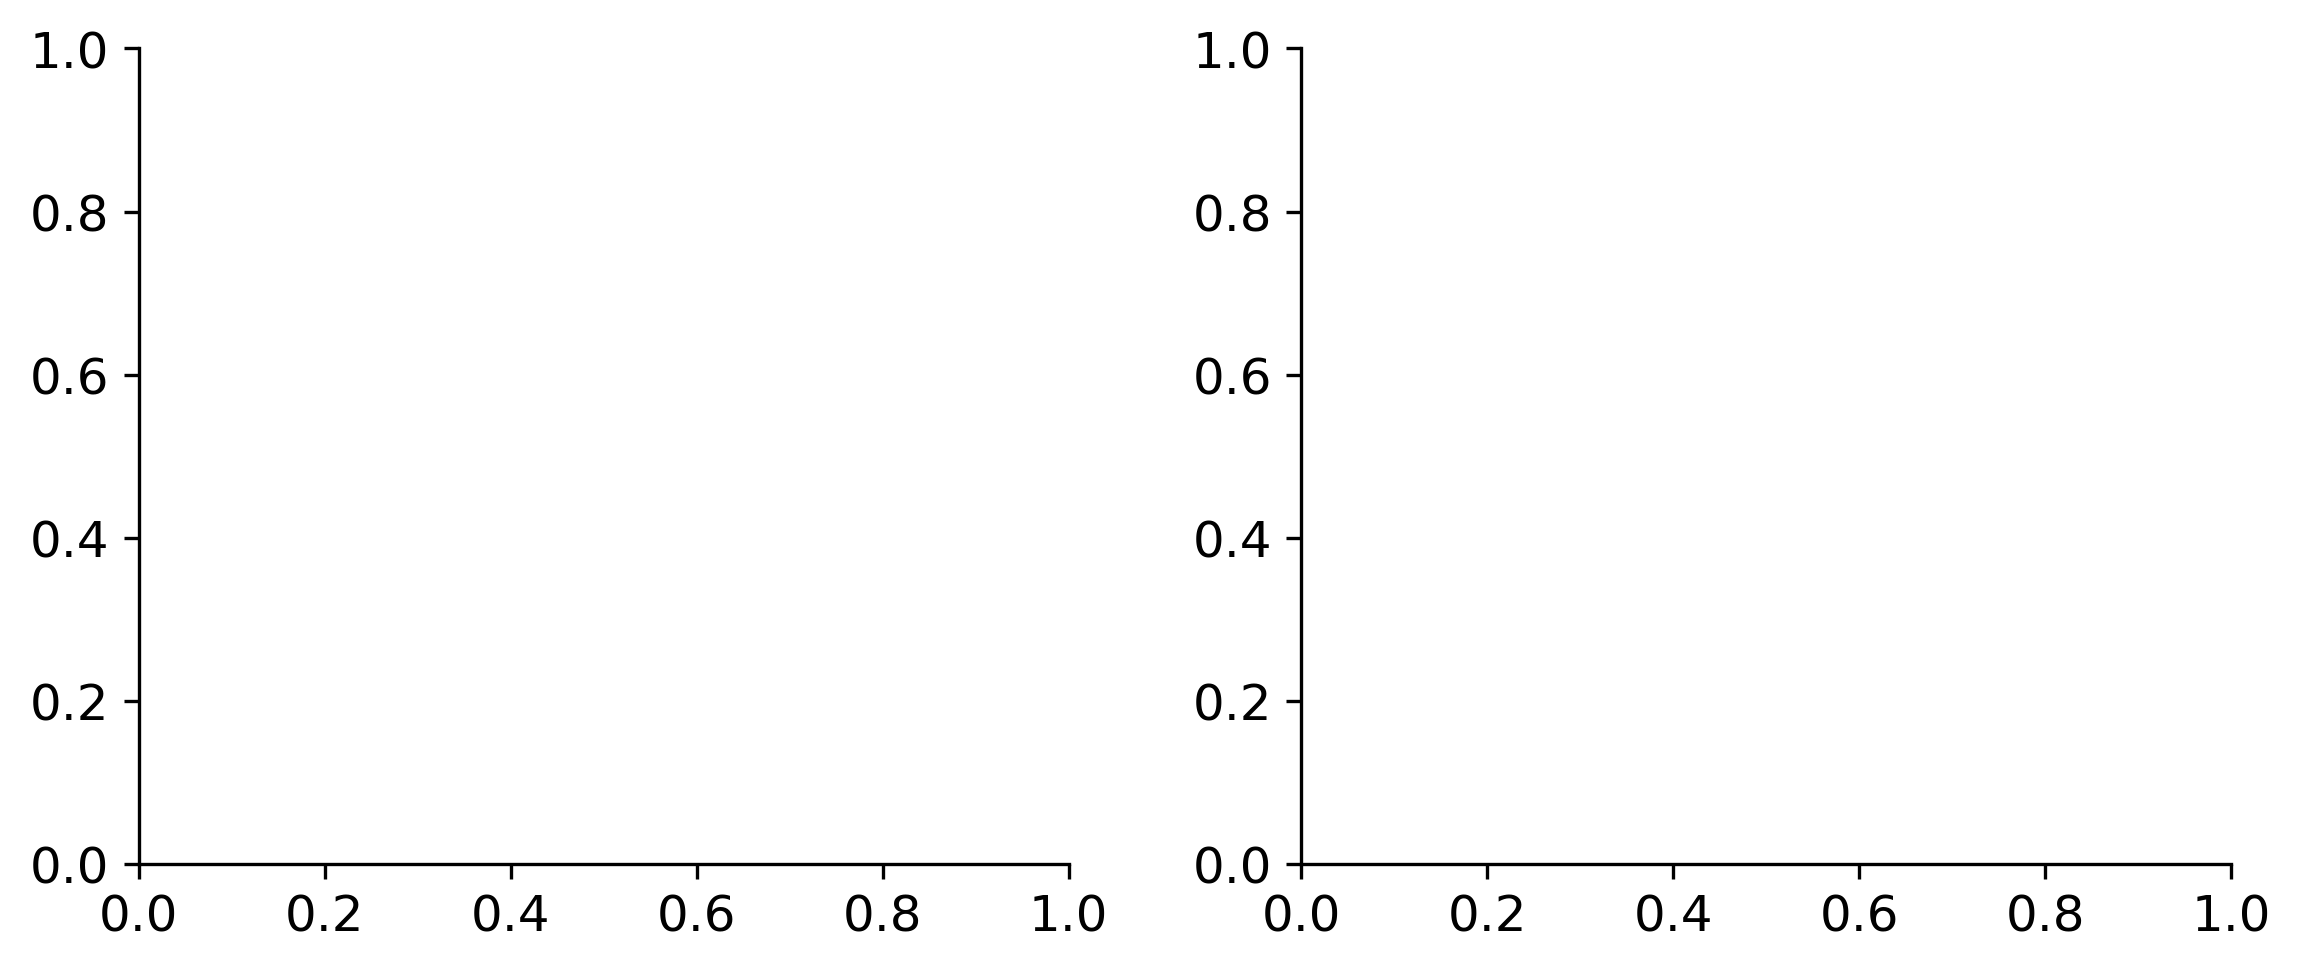

In [50]:
plt.close()
fig, ax = plt.subplots(1, 2, figsize=(9, 3.6), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i], maze_map, mask = draw_maze_precise(events,
                                          trav_by_pos,
                                          scaling_factor=scaling_factor,
                                          do_convolve=False,
                                          all_pos=all_pos,
                                          show_nav=True,
                                          draw_base=True,
                                          square=True,
                                          cmap='rocket',
                                          cbar_label='No. traversals',
                                          ax=ax[i])

i = 1
ax[i], maze_map, mask = draw_maze_precise(events,
                                          fr_by_pos,
                                          scaling_factor=scaling_factor,
                                          do_convolve=False,
                                          all_pos=all_pos,
                                          show_nav=True,
                                          draw_base=True,
                                          square=True,
                                          cmap='rocket',
                                          alpha_nav=0.2,
                                          cbar_label='Firing rate (Hz)',
                                          ax=ax[i])

fig.tight_layout()

AttributeError: 'collections.OrderedDict' object has no attribute 'event_times'

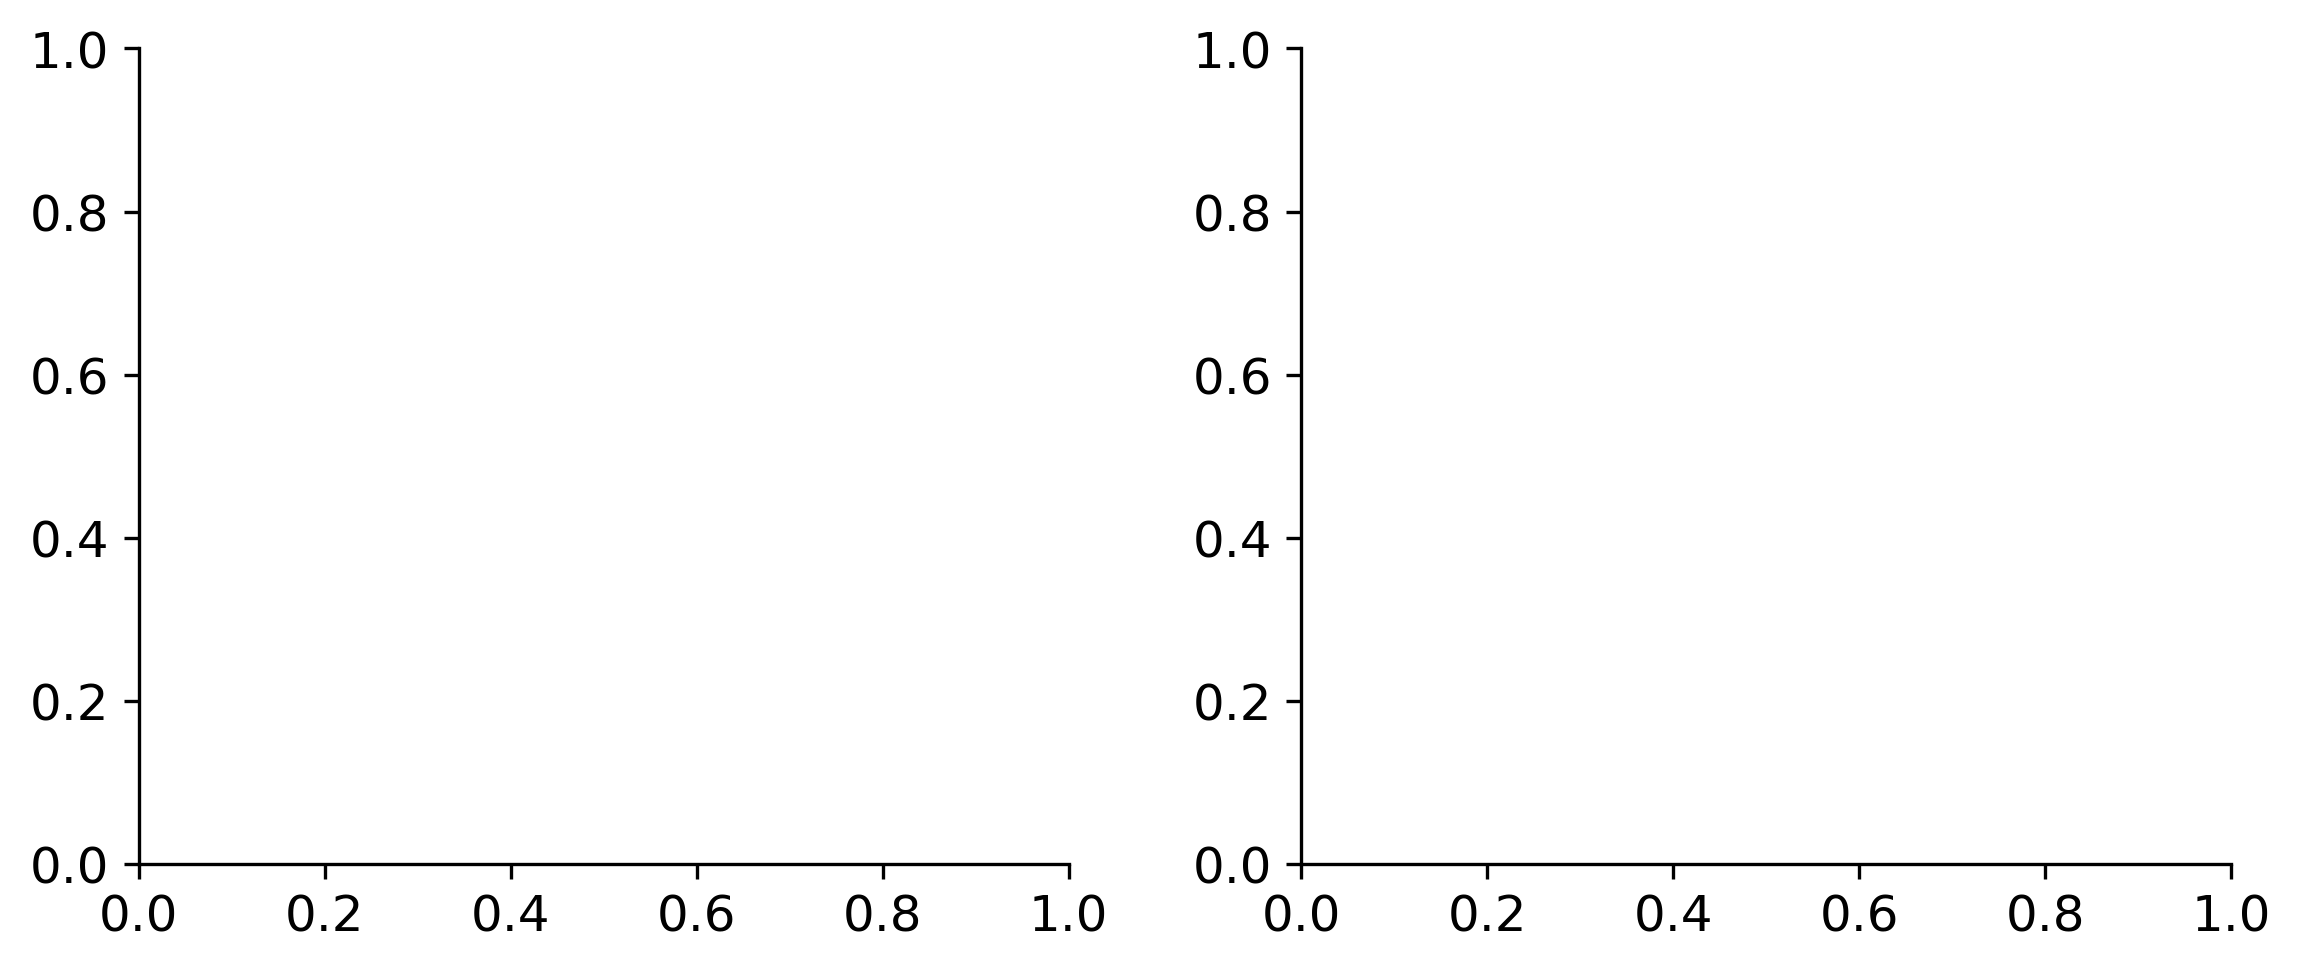

In [51]:
iUnit = 31
scaling_factor = 1

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(9, 3.6), dpi=300)
ax = np.ravel(ax)
neuron = dio.open_pickle(files[iUnit])
all_pos = od([])
fr_by_pos = od([])
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    event_times_ = events.event_times.query("(gameState=='{}')".format(game_state)).copy()
    event_times_['spike_train'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times'], sigma=0))
    spike_train_vec = np.concatenate(event_times_['spike_train'].tolist())
    event_times_['fr'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times']))
    fr_vec = np.concatenate(event_times_['fr'].tolist())

    positions_ = events.positions.query("(gameState=='{}')".format(game_state)).copy()
    all_pos[game_state] = od([])
    for trial, df in positions_.groupby('trial'):
        fr_arr = np.expand_dims(pd.merge(df[['gameState', 'trial', 'time', 'pos']], event_times_[['gameState', 'trial', 'time', 'fr']], 
                                         how='left', on=['gameState', 'trial']).apply(lambda x: x['fr'][x['time_x'] - x['time_y'][0]], axis=1),
                                axis=-1)
        all_pos[game_state][trial] = np.concatenate((np.array(df['pos'].tolist()) * scaling_factor, fr_arr), axis=-1)

    positions_['pos'] = positions_['pos'].apply(lambda x: (np.int(x[0]*scaling_factor), np.int(x[1]*scaling_factor)))
    idx_to_pos = positions_['pos'].value_counts().reset_index()['index'].to_dict()
    pos_to_idx = {v:k for k, v in idx_to_pos.items()}
    pos_vec = np.concatenate(positions_.apply(lambda x: pos_to_idx[x['pos']] * np.ones(x['dur']), axis=1).tolist())
    assert len(pos_vec) == len(fr_vec)
    dur_by_pos = {idx_to_pos[idx]:len(np.where(pos_vec==idx)[0]) for idx in idx_to_pos.keys()}
    trav_by_pos = events.pos_intervals.query("(gameState=='{}')".format(game_state))['pos'].apply(lambda x: (x[0]*scaling_factor, x[1]*scaling_factor)).value_counts().to_dict()
    fr_by_pos[game_state] = {idx_to_pos[idx]:np.mean(fr_vec[np.where(pos_vec==idx)[0]]) for idx in idx_to_pos.keys()}
    
vmin = 0
vmax = np.max(np.concatenate([np.array(list(fr_by_pos[game_state].values())) for game_state in fr_by_pos.keys()]))
    
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    ax[i], maze_map, mask = draw_maze_precise(events,
                                              fr_by_pos[game_state],
                                              all_pos=all_pos[game_state],
                                              vmin=vmin,
                                              vmax=vmax,
                                              scaling_factor=scaling_factor,
                                              do_convolve=False,
                                              show_nav=True,
                                              draw_base=True,
                                              square=True,
                                              cmap='rocket',
                                              alpha_nav=0.25,
                                              cbar_label='Firing rate (Hz)',
                                              ax=ax[i])
    ax[i].set_title(game_state, fontsize=events.plot_params['font']['fig'], pad=8)

fig.tight_layout()

AttributeError: 'collections.OrderedDict' object has no attribute 'event_times'

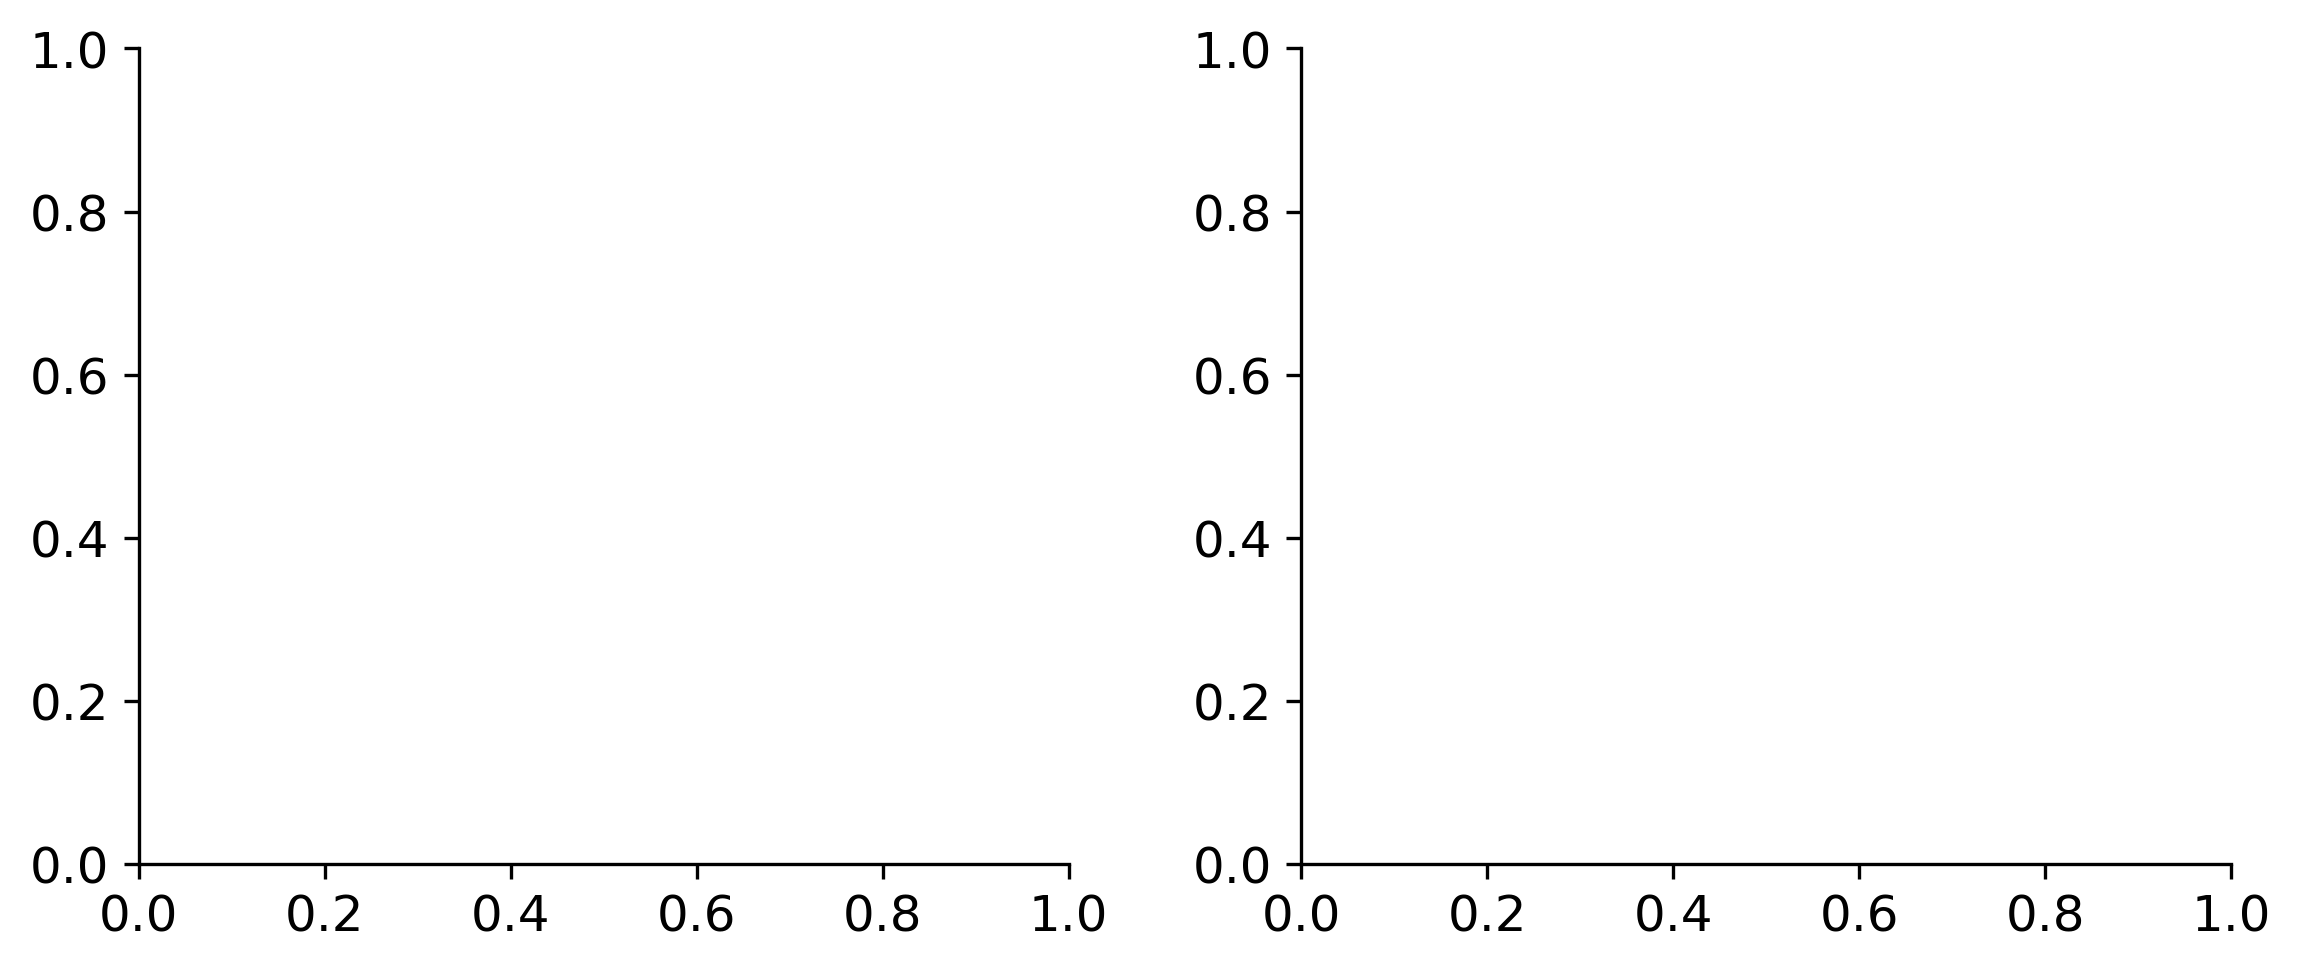

In [52]:
on = 'maze_idx'
min_traversals = 0
iUnit = 32

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(9, 3.6), dpi=300)
ax = np.ravel(ax)
neuron = dio.open_pickle(files[iUnit])
fr_by_pos = od([])
for i, game_state in enumerate(['Encoding', 'Retrieval']):
    event_times_ = events.event_times.query("(gameState=='{}')".format(game_state)).copy()
    event_times_['fr'] = event_times_['time'].apply(lambda x: spike_preproc.apply_spike_times_to_fr(x, neuron['spike_times']))
    fr_vec = np.concatenate(event_times_['fr'].tolist())
    pos_intervals_ = events.pos_intervals.query("(gameState=='{}')".format(game_state))
    pos_keys = list(pos_intervals_[on].unique())
    pos_vec = np.concatenate(pos_intervals_.apply(lambda x: x[on] * np.ones(x['dur']), axis=1).tolist())
    assert len(fr_vec) == len(pos_vec)
    pos_durs = {k: len(np.where(pos_vec==k)[0]) for k in pos_keys}
    pos_traversals = {k:pos_intervals_.groupby('maze_idx').size().to_dict().get(k, 0)
                      for k in events.maze.maze.query("(region!='wall')").index.tolist()}
    fr_by_pos[game_state] = {k: np.mean(fr_vec[np.where(pos_vec==k)[0]])
                             for k in pos_keys
                             if (pos_traversals.get(k, 0)>=min_traversals)}
vmin = 0
vmax = np.max(np.concatenate([np.array(list(fr_by_pos[game_state].values())) for game_state in fr_by_pos.keys()]))

for i, game_state in enumerate(['Encoding', 'Retrieval']):
    if i == len(ax) - 1:
        cbar_label = 'Firing rate (Hz)'
    else:
        cbar_label = ''
    ax[i], *_ = events.draw_maze(fr_by_pos[game_state],
                                 vmin=vmin,
                                 vmax=vmax,
                                 cmap='rocket',
                                 square=True,
                                 show_nav=True,
                                 game_state=game_state,
                                 color_nav='w',
                                 cbar_label=cbar_label,
                                 ax=ax[i])
    ax[i].set_title(game_state, fontsize=events.plot_params['font']['fig'], pad=8)
    
fig.tight_layout()

In [53]:
iUnit = 21
idx_on = 'maze_idx_hd'
game_states = ['Encoding', 'Retrieval']
min_traversals = 0

neuron = dio.open_pickle(files[iUnit])
fr_by_pos = place_analysis.calc_fr_by_pos(neuron,
                                          events.event_times,
                                          pos_time_idx)

plt.close()
fig, ax = plt.subplots(2, 4, figsize=(12, 5), dpi=300)
ax = np.ravel(ax)

vmin = 0
vmax = np.max([list(fr_by_pos[game_state].values()) for game_state in fr_by_pos.keys()])

for iRow, game_state in enumerate(game_states):
    i = (4*iRow) + 0
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    ax[i].set_ylabel(game_state, fontsize=events.plot_params['font']['fig'], labelpad=8)
    if iRow == 0:
        ax[i].set_title('North', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 1
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.5)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('South', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 2
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.75)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('West', fontsize=events.plot_params['font']['fig'], pad=8)

    i = (4*iRow) + 3
    cbar_label = 'Firing rate (Hz)' if (iRow == 1) else ''
    ax[i], *_ = events.draw_maze({k: fr_by_pos[game_state][k] 
                                  for k in fr_by_pos[game_state] if (k%1 == 0.25)},
                                 vmin=vmin,
                                 vmax=vmax,
                                 square=True,
                                 show_nav=False,
                                 color_base='w',
                                 cbar_label=cbar_label,
                                 ax=ax[i])
    if iRow == 0:
        ax[i].set_title('East', fontsize=events.plot_params['font']['fig'], pad=8)

fig.tight_layout()

AttributeError: module 'time_cells.place_analysis' has no attribute 'calc_fr_by_pos'

# Primary head direction

In [54]:
import astropy.stats.circstats as circstats
import pycircstat

ModuleNotFoundError: No module named 'pycircstat'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


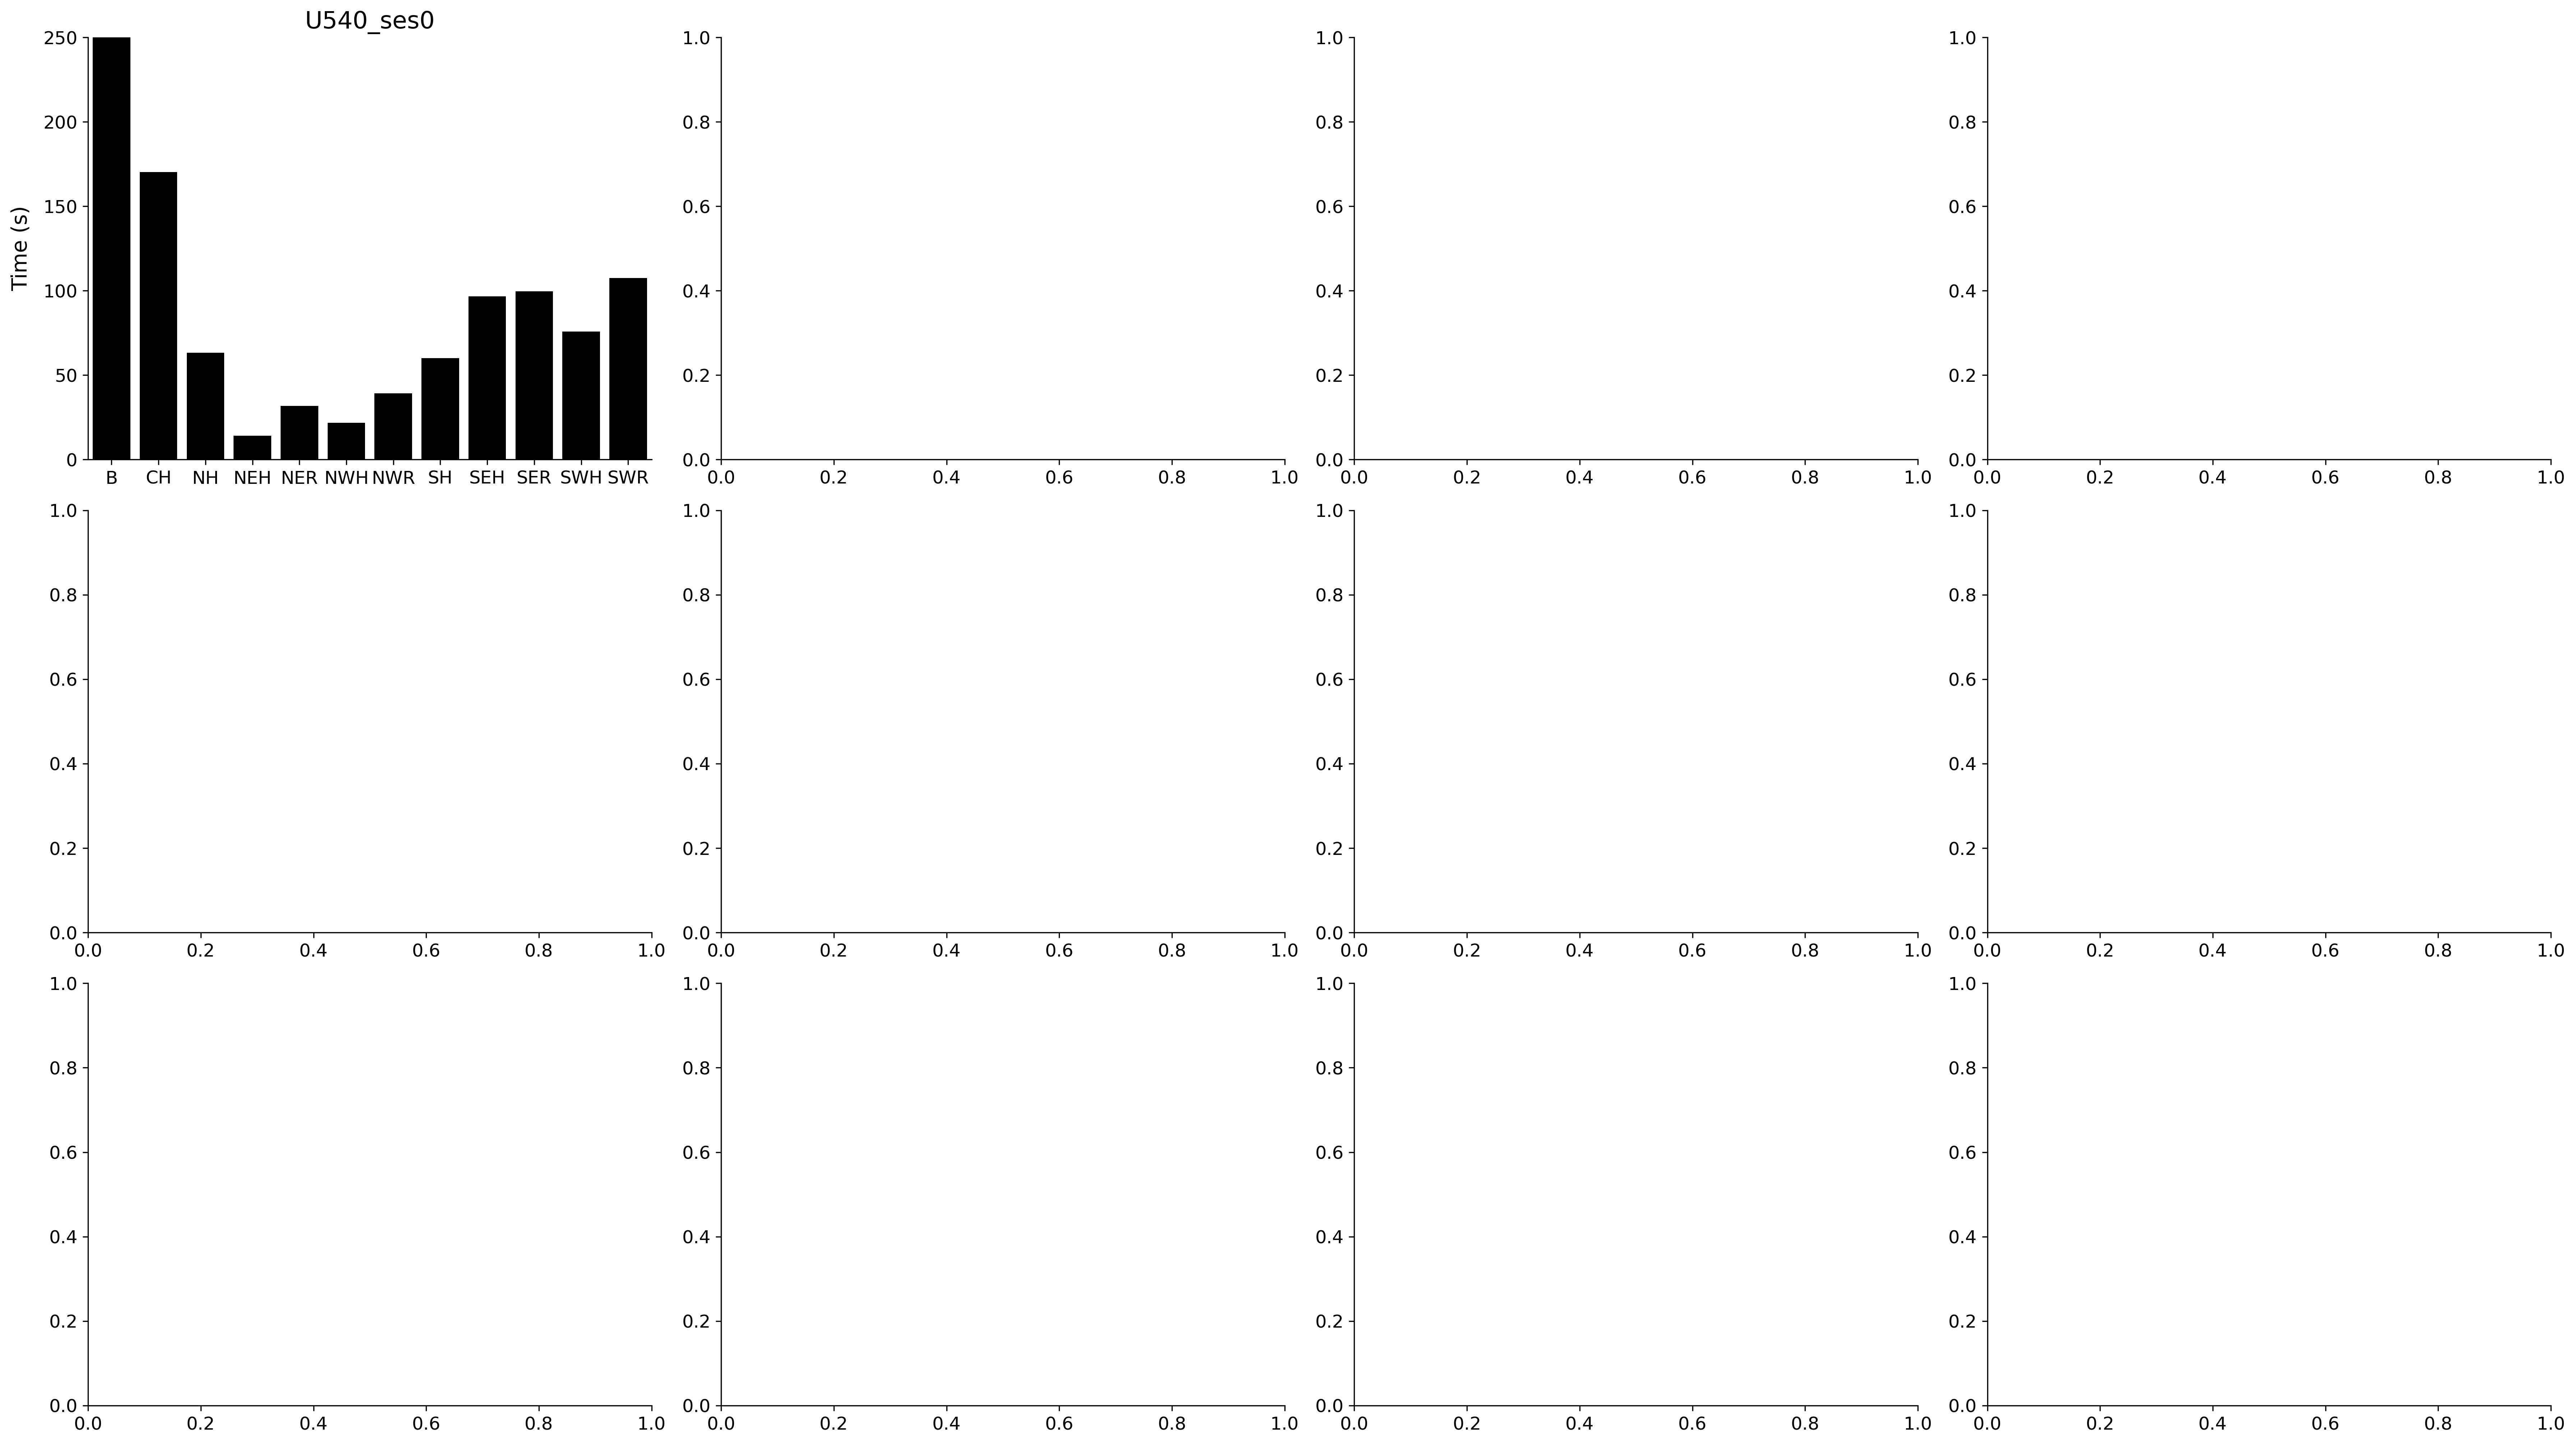

In [55]:
ylim = [0, 250]
yticks = [0, 50, 100, 150, 200, 250]
abbvs = {'Base': 'B',
         'C Hall': 'CH',
         'N Passage': 'NH',
         'NE Hall': 'NEH',
         'NE Room': 'NER',
         'NW Hall': 'NWH',
         'NW Room': 'NWR',
         'S Passage': 'SH',
         'SE Hall': 'SEH',
         'SE Room': 'SER',
         'SW Hall': 'SWH',
         'SW Room': 'SWR'}

plt.close()
fig, ax = plt.subplots(3, 4, figsize=(24, 13.5), dpi=300)
ax = np.ravel(ax)

mean_df = []
iax = 0
for iax, subj_sess in enumerate(events.keys()):
    positions = events[subj_sess].positions.query("(gameState=='Encoding')").reset_index(drop=True)
    positions['region_abbv'] = positions['maze_region'].apply(lambda x: abbvs[x])
    region_abbvs = ['B', 'CH', 'NH', 'NEH', 'NER', 'NWH', 'NWR', 'SH', 'SEH', 'SER', 'SWH', 'SWR']
    positions['region_abbv'] = positions['region_abbv'].astype(pd.CategoricalDtype(region_abbvs, ordered=True))
    _df = (positions#.query("(region_abbv!='B')")
                    .groupby('region_abbv', observed=True)['dur']
                    .apply(lambda x: np.sum(x) * 1e-3)
                    .reset_index()
                    .rename(columns={0: 'count'}))
    mean_df.append(_df)
    ax[iax] = sns.barplot(data=_df, x='region_abbv', y='dur', ax=ax[iax],
                          color='k')
    ax[iax].set_ylim(ylim)
    ax[iax].set_yticks(yticks)
    ax[iax].set_yticklabels(yticks)
    ax[iax].set_xlabel('')
    if (iax % 4) == 0:
        ax[iax].set_ylabel('Time (s)')
    else:
        ax[iax].set_ylabel('')
    ax[iax].set_title(subj_sess)
    
fig.tight_layout()
fig.set_facecolor('w')
fig.show()

In [56]:
abbvs = {'Base': 'B',
         'C Hall': 'CH',
         'N Passage': 'NH',
         'NE Hall': 'NEH',
         'NE Room': 'NER',
         'NW Hall': 'NWH',
         'NW Room': 'NWR',
         'S Passage': 'SH',
         'SE Hall': 'SEH',
         'SE Room': 'SER',
         'SW Hall': 'SWH',
         'SW Room': 'SWR'}
# region_abbvs = ['B', 'CH', 'NH', 'NEH', 'NER', 'NWH', 'NWR', 'SH', 'SEH', 'SER', 'SWH', 'SWR']
region_abbvs = ['B', 'SH', 'CH', 'NH', 'SWH', 'SWR', 'NWR', 'NWH', 'SEH', 'SER', 'NER', 'NEH']

positions = []
for subj_sess in events:
    subj, sess = subj_sess.split('_')
    _positions = events[subj_sess].positions.query("(gameState==['Encoding', 'Retrieval'])")
    _positions.insert(0, 'subj', subj)
    _positions.insert(1, 'subj_sess', subj_sess)
    positions.append(_positions)

positions = pd.concat(positions).reset_index(drop=True)
positions['region_abbv'] = positions['maze_region'].apply(lambda x: abbvs[x])

pos_durs = positions.groupby(['subj', 'subj_sess', 'gameState', 'region_abbv'])['dur'].apply(lambda x: np.sum(x) * 1e-3).reset_index()
pos_durs = pos_durs.groupby(['subj', 'gameState', 'region_abbv'])['dur'].apply(np.mean).reset_index()
pos_durs['region_abbv'] = pos_durs['region_abbv'].astype(pd.CategoricalDtype(region_abbvs, ordered=True))
pos_durs = pos_durs.sort_values(['region_abbv', 'subj', 'gameState']).reset_index(drop=True)

print(positions.shape, pos_durs.shape)

(43159, 18) (24, 4)


In [57]:
pos_durs

,subj,gameState,region_abbv,dur
0,U540,Encoding,B,299.879
1,U540,Retrieval,B,475.329
2,U540,Encoding,SH,60.049
3,U540,Retrieval,SH,52.578
4,U540,Encoding,CH,170.323
5,U540,Retrieval,CH,102.284
6,U540,Encoding,NH,63.337
7,U540,Retrieval,NH,30.413
8,U540,Encoding,SWH,75.897
9,U540,Retrieval,SWH,70.515


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/numpy/cor

FileNotFoundError: [Errno 2] No such file or directory: '/home1/cjmac/projects/time_cells/figs/plot_behav/time_spent_per_maze_region-Encoding_Retrieval-1subjs.pdf'

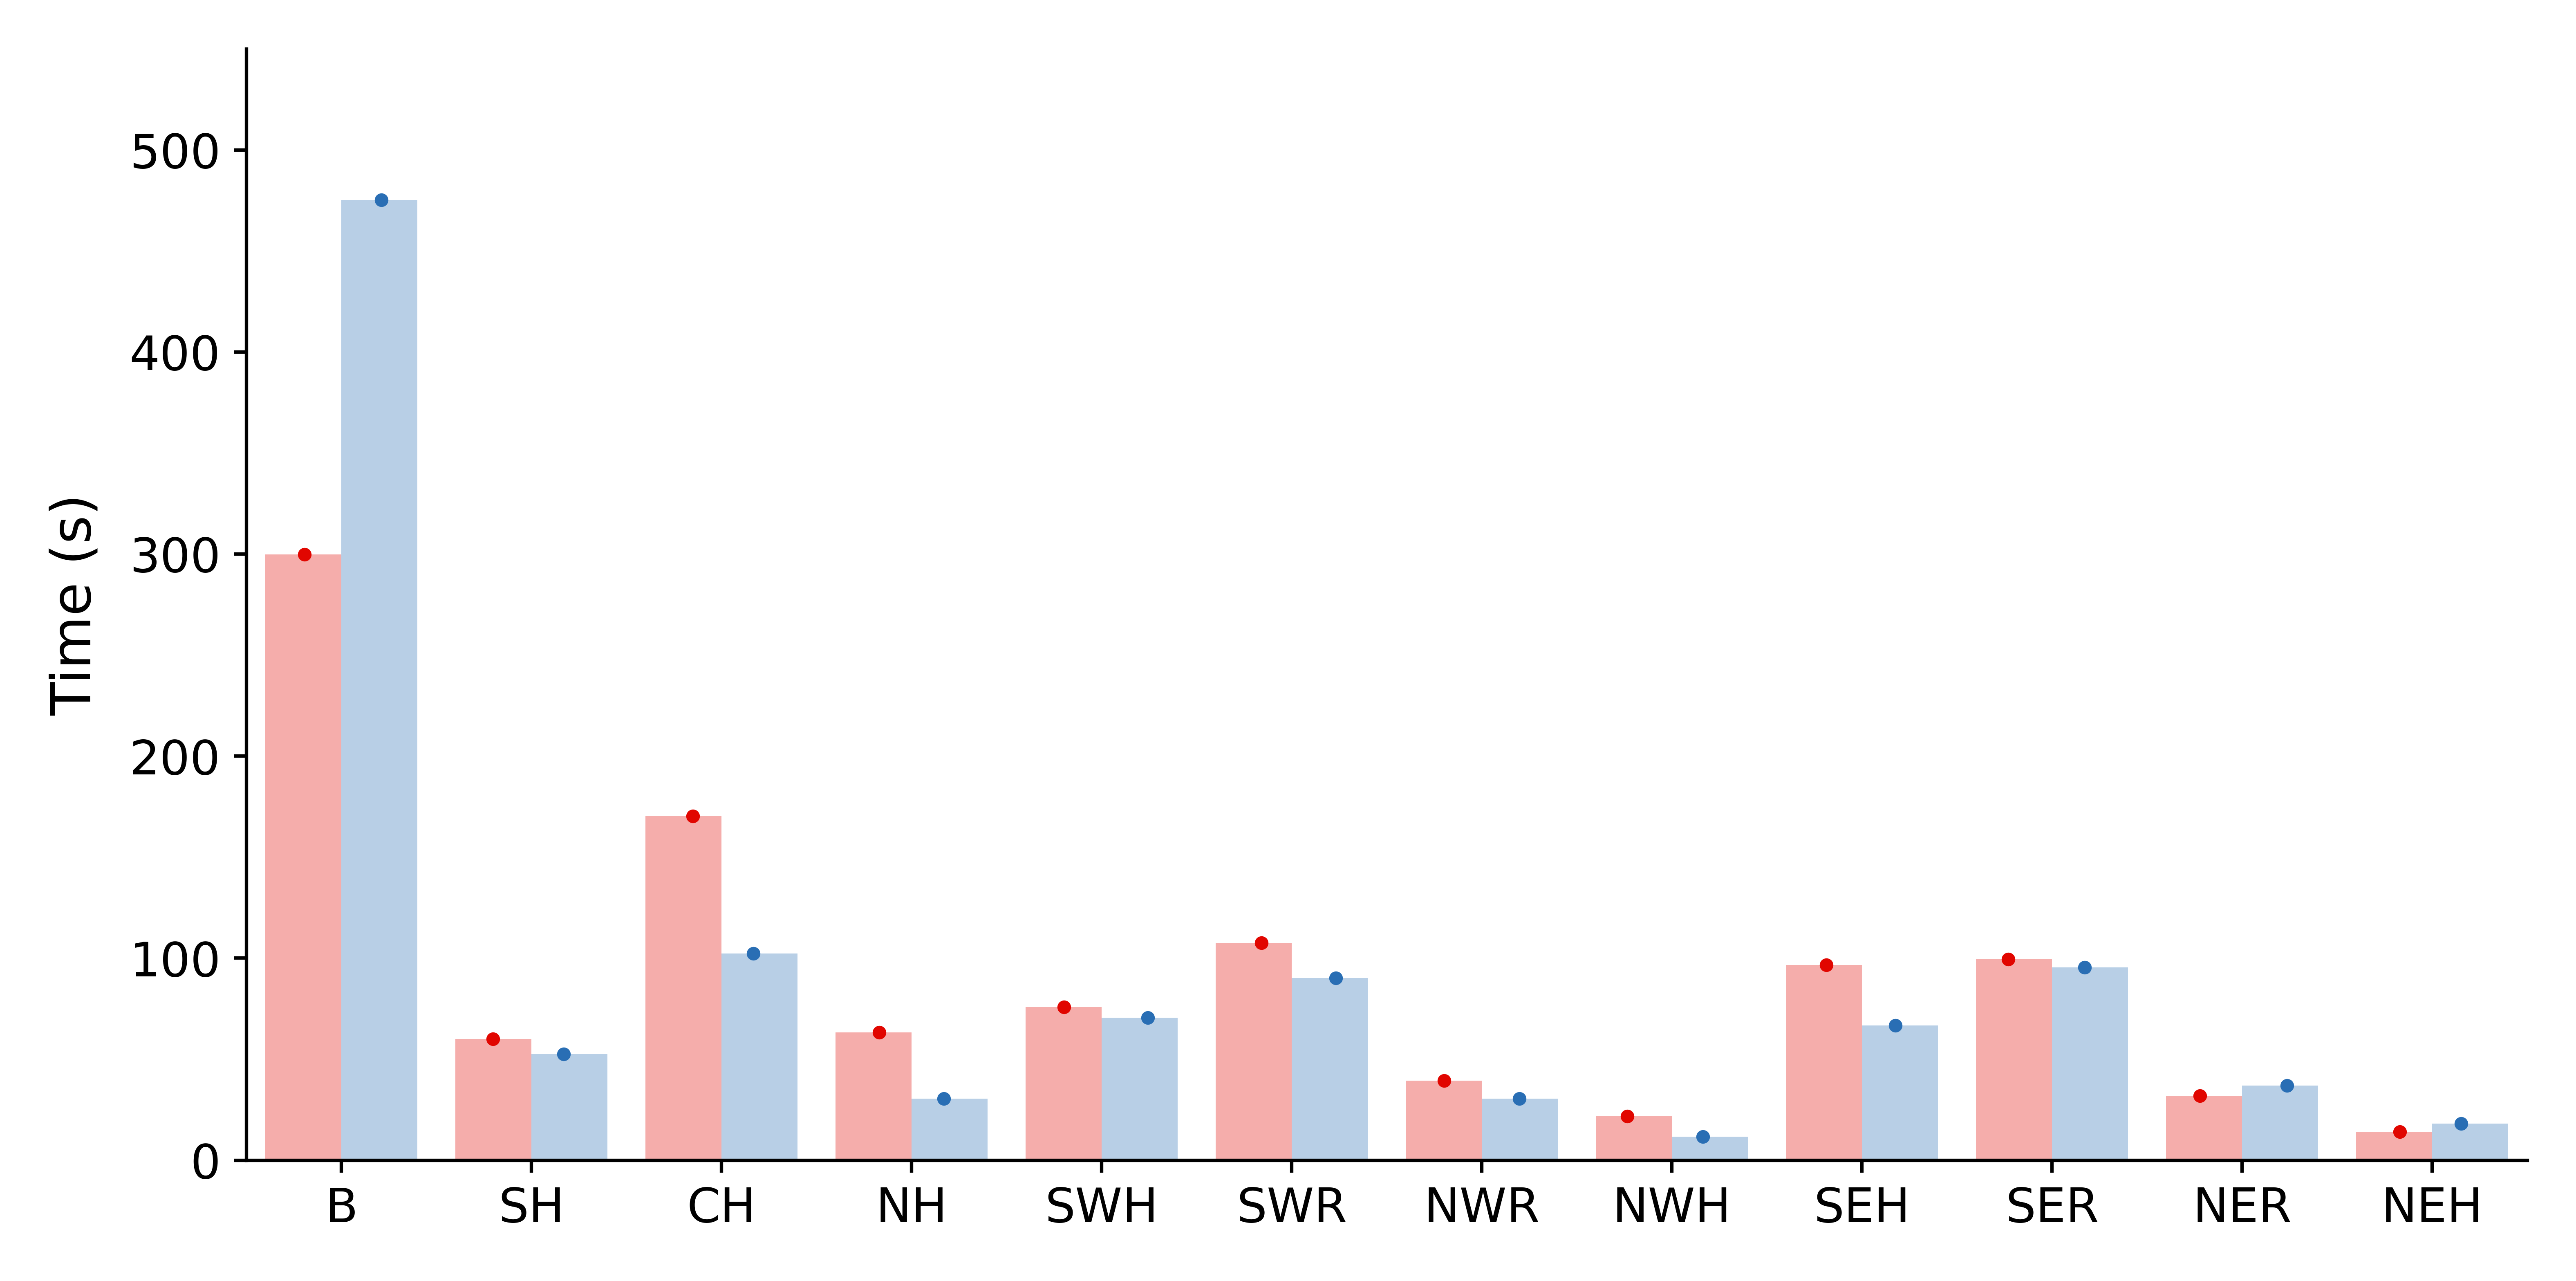

In [58]:
savefig = 1
overwrite = 0
ymin = 0
ymax = 550
yticks = [0, 100, 200, 300, 400, 500]
game_states = ['Encoding', 'Retrieval']
figsize = (6, 3)
dpi = 1200
font = {'tick': 7, 'label': 8, 'annot': 10, 'fig': 12}
spine_len = 1.8
spine_lw = 0.5
spine_pad = 1
labelpad = 4
tickpad = 2
alpha = 0.33
capsize = 3
ebar_lw = 0.75
fliersize = 2

# --------------------
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.barplot(x='region_abbv', y='dur', hue='gameState', data=pos_durs, ax=ax[iax],
                      ci=None, palette=['#e10600', '#296eb4'], saturation=1, alpha=alpha)
ax[iax].errorbar(np.arange(len(region_abbvs))-0.2,
                 pos_durs.query("(gameState=='Encoding')").groupby('region_abbv', sort=False)['dur'].mean().values,
                 yerr=pos_durs.query("(gameState=='Encoding')").groupby('region_abbv', sort=False)['dur'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=capsize, capthick=ebar_lw, linewidth=0)
ax[iax].errorbar(np.arange(len(region_abbvs))+0.2,
                 pos_durs.query("(gameState=='Retrieval')").groupby('region_abbv', sort=False)['dur'].mean().values,
                 yerr=pos_durs.query("(gameState=='Retrieval')").groupby('region_abbv', sort=False)['dur'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=capsize, capthick=ebar_lw, linewidth=0)
ax[iax] = sns.stripplot(x='region_abbv', y='dur', hue='gameState', data=pos_durs, ax=ax[iax],
                        palette=['#e10600', '#296eb4'], size=fliersize, alpha=1, dodge=True, jitter=0.1)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(len(region_abbvs)))
ax[iax].set_xticklabels(region_abbvs, fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin, ymax])
ax[iax].set_yticks(yticks)
ax[iax].set_yticklabels(yticks, fontsize=font['tick'])
ax[iax].set_ylabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].get_legend().remove()

if savefig:
    filename = op.join(proj_dir, 'figs', 'plot_behav',
                       'time_spent_per_maze_region-Encoding_Retrieval-{}subjs.pdf'
                       .format(pos_durs['subj'].unique().size))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)
        
fig.show()

In [ ]:
pd.concat(mean_df).groupby('region_abbv')['dur'].mean().reset_index()

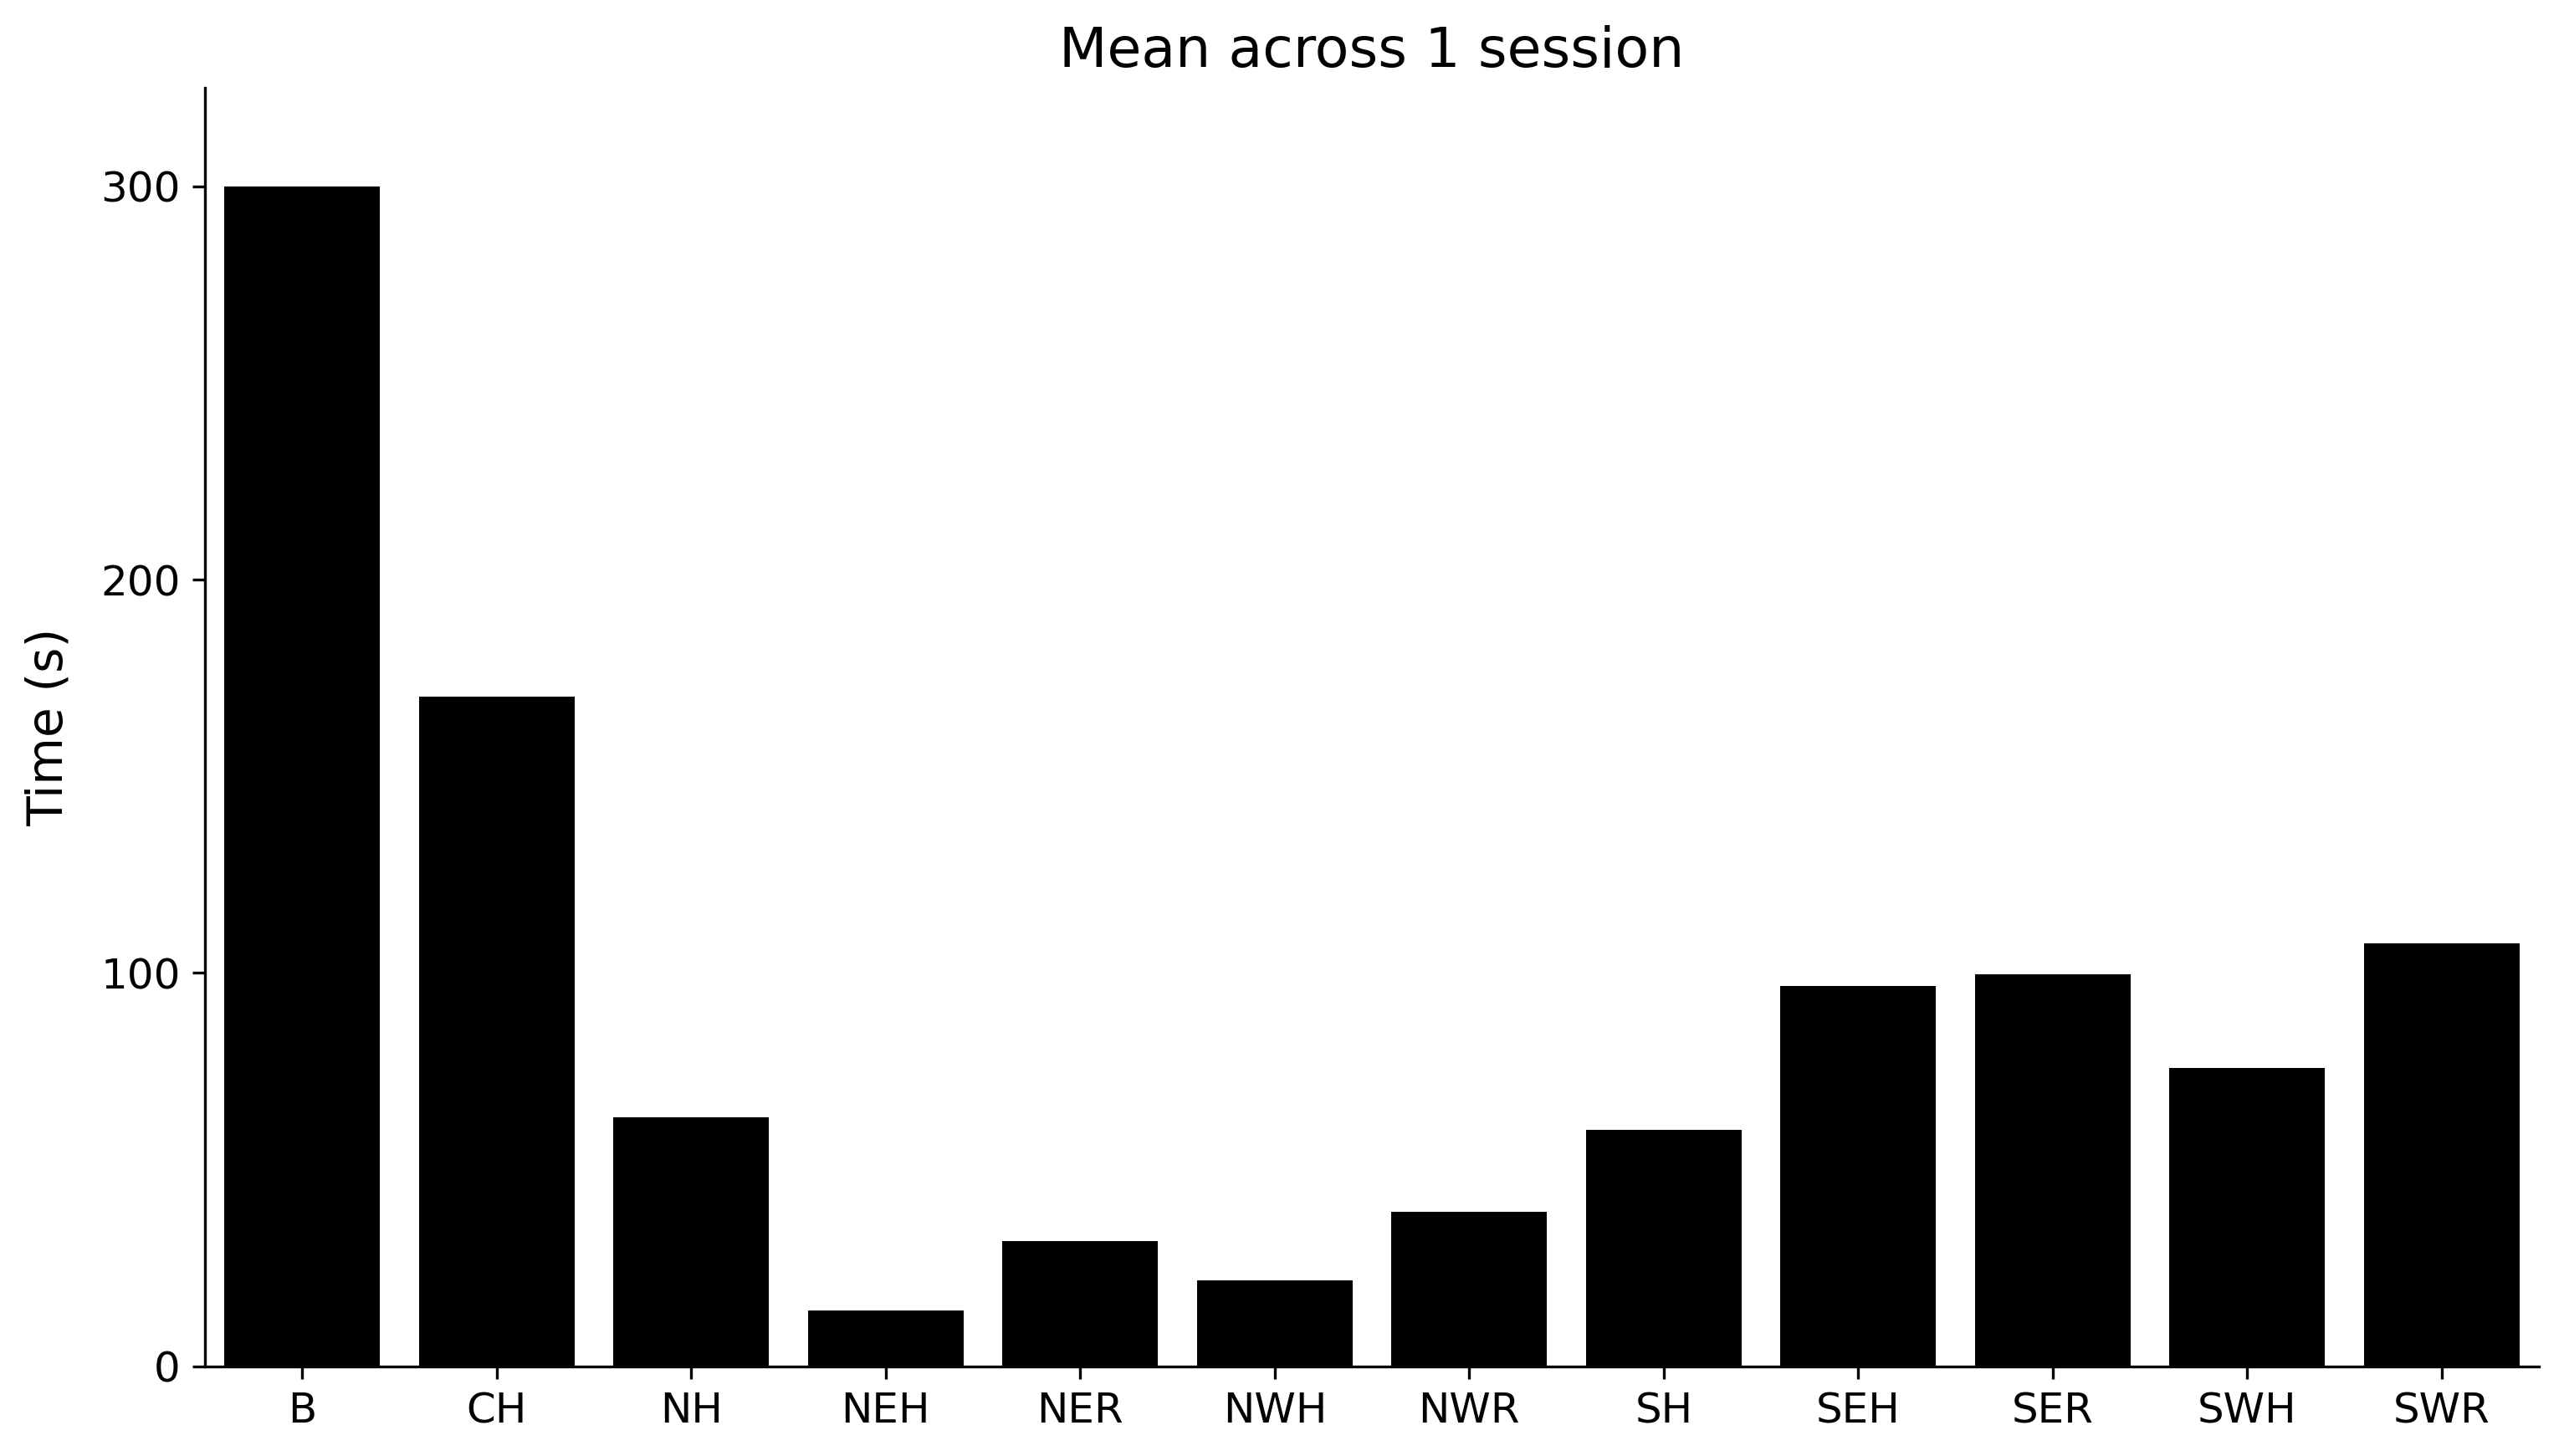

In [59]:
ylim = [0, 325]
yticks = [0, 100, 200, 300]

_df = pd.concat(mean_df).groupby('region_abbv')['dur'].mean().reset_index()

plt.close()
fig, ax = plt.subplots(1, 1, figsize=(12, 13.5/2), dpi=300)
ax = np.ravel(ax)

iax = 0
ax[iax] = sns.barplot(data=_df, x='region_abbv', y='dur', ax=ax[iax],
                      color='k')
ax[iax].set_ylim(ylim)
ax[iax].set_yticks(yticks)
ax[iax].set_yticklabels(yticks)
ax[iax].set_xlabel('')
ax[iax].set_ylabel('Time (s)')
ax[iax].set_title('Mean across {} session'.format(len(mean_df)))

fig.set_facecolor('w')
fig.show()

In [60]:
_gold_events.groupby('gold_id')['time'].apply(lambda x: np.mean(np.diff(x)))

NameError: name '_gold_events' is not defined

In [61]:
#events[subj_sess].gold_spawned

In [62]:
_gold_events = events[subj_sess].gold_events.query("(gameState=='Encoding')").reset_index(drop=True)

_gold_events.query("(in_view==True)").groupby('gold_id').size() * 250 * 1e-3

gold_id
gold0003    12.00
gold0004     5.25
gold0006     3.50
gold0007     2.50
gold0010     3.25
gold0012     2.75
gold0016     2.50
gold0017     2.75
gold0018     3.00
gold0020     6.00
gold0023     1.75
gold0024     3.75
gold0025     2.50
gold0027     2.25
gold0028     3.75
gold0029     2.50
gold0030     4.50
gold0031     5.25
gold0034     3.25
gold0035     0.50
gold0037     3.25
gold0039     1.25
gold0041    24.75
gold0042     2.75
gold0043     3.25
gold0044     6.25
gold0047    11.50
dtype: float64

In [63]:
def deg2rad(angles):
    """Convert angles from degree to radian."""
    angles %= 360.0
    angles = (angles / 360.0) * (2 * np.pi)
    return angles

def rad2deg(angles):
    """Convert angles from radian to degree."""
    angles %= (2 * np.pi)
    angles = (angles / (2 * np.pi)) * 360.0
    return angles

In [64]:
positions.query("(region_abbv!='B')").groupby('region_abbv', observed=True).size().reset_index().rename(columns={0: 'count'})


,region_abbv,count
0,CH,5450
1,NEH,647
2,NER,1365
3,NH,1864
4,NWH,671
5,NWR,1394
6,SEH,3261
7,SER,3888
8,SH,2251
9,SWH,2926


In [65]:
subj_sess = sessions[-1]
print(subj_sess)


positions = events[subj_sess].positions.query("(gameState=='Encoding')").reset_index(drop=True)
positions['region_abbv'] = positions['maze_region'].apply(lambda x: abbvs[x])
region_abbvs = ['B', 'CH', 'NP', 'NEH', 'NER', 'NWH', 'NWR', 'SP', 'SEH', 'SER', 'SWH', 'SWR']
positions['region_abbv'] = positions['region_abbv'].astype(pd.CategoricalDtype(region_abbvs, ordered=True))

positions.groupby(['maze_region']).agg({'dur': len,
                                        'rotation': [lambda x: rad2deg(circstats.circmean(deg2rad(x))),
                                                     lambda x: pycircstat.omnibus(deg2rad(x)),
                                                     lambda x: circstats.rayleightest(deg2rad(x))]})

U540_ses0


NameError: name 'pycircstat' is not defined

# Older position code

In [66]:
# Where did the subject go in the mine?
min_traversals = 0

# -------------------------------------
cols = ['trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
game_states = ['Encoding', 'Retrieval', 'ReturnToBase1', 'ReturnToBase1']
mask_regions = ['wall', 'base']
traversals = []
for idx, df in (events.query("(key=='playerTransform') & (gameState=={})".format(game_states))
                .groupby(['trial', 'gameState'])):
    trial, gameState = idx
    if maze_name == 'SimpleMaze':
        pos = np.array(df['value'].apply(lambda x: (int(x['positionX'])-4, int(x['positionZ'])-1)).tolist(), time_bin_analysis.)
    else:
        pos = np.array(df['value'].apply(lambda x: (int(x['positionX']), int(x['positionZ']))).tolist(), time_bin_analysis.)
    dist_trav = np.concatenate(([0], np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))))
    traversals.extend([x for x in pos[dist_trav>0]])
traversals = np.array(traversals)
positions, counts = np.unique(traversals, axis=0, return_counts=True)

maze_map = np.zeros([27, 29])
for iPos in range(len(positions)):
    maze_map[tuple(positions[iPos])] = counts[iPos]

# Mask out unwanted regions.
mask = np.zeros([27, 29])
for region in mask_regions:
    for idx, row in maze.query("(region=='{}')".format(region)).iterrows():
        (xmin, zmin), (xmax, zmax) = row.coords
        for x in range(xmin, xmax):
            for z in range(zmin, zmax):
                maze_map[x, z] = 0
                mask[x, z] = 1

# Mask out squares that the subject didn't visit.
maze_map[maze_map<min_traversals] = 0

print('{} squares traversed'.format(maze_map[maze_map>0].size))
print('No. traversals: median {:.1f}, max {:.1f}, sum {:.0f}'.format(np.median(maze_map[maze_map>0]), 
                                                                     np.max(maze_map), 
                                                                     np.sum(maze_map)))

SyntaxError: invalid syntax (<ipython-input-66-80e66f7ba8aa>, line 13)

NameError: name 'maze_map' is not defined

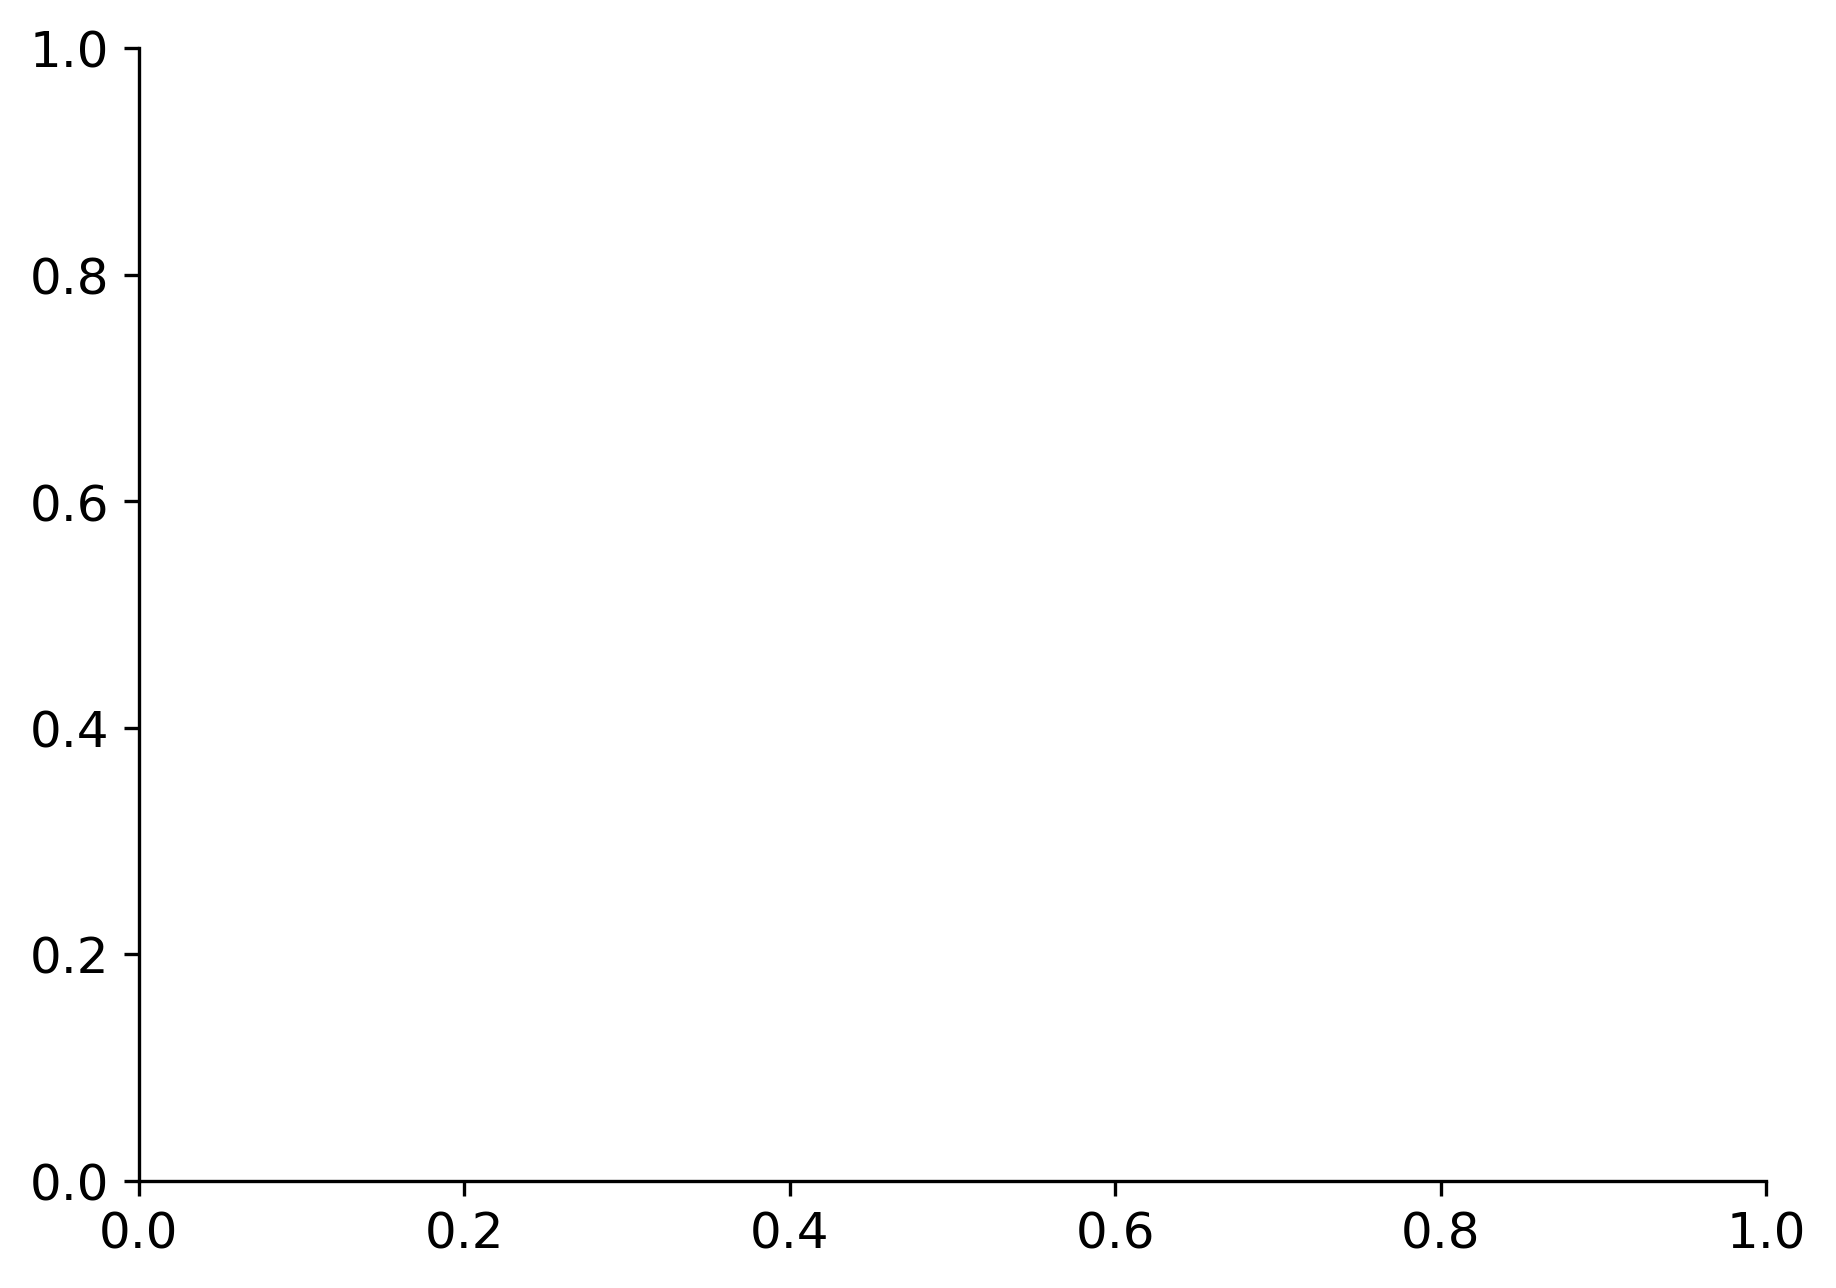

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14
cmap = [(0, 0, 0)] + sns.color_palette('viridis', 500)

i = 0
ax[i] = sns.heatmap(maze_map.T[::-1], vmin=min_traversals, vmax=np.max(maze_map),
                    square=True, cmap='viridis', mask=mask.T[::-1], ax=ax[i])
ax[i].annotate('BASE', (13.5, 26), color='w', fontsize=labelfontsize, ha='center')
ax[i].set_facecolor('k')

ax[i].set_xticks([])
ax[i].set_yticks([])
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.arange(min_traversals, np.max(maze_map)+1, 15, dtype=int))
cbar.set_ticklabels(np.arange(min_traversals, np.max(maze_map)+1, 15, dtype=int))
cbar.set_label('No. traversals', fontsize=tickfontsize, labelpad=5)

fig.show()

In [ ]:
# How much distance is traveled, and how much time spent moving vs. standing still?
cols = ['sess', 'trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
travel = []
positions = []
for idx, df in events.query("(key=='playerTransform') & (gameState==['Encoding', 'Retrieval'])").groupby(['sess', 'trial', 'gameState']):
    sess, trial, gameState = idx
    pos = np.array(df['value'].apply(lambda x: (x['positionX'], x['positionZ'])).tolist())
    dist_trav = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    travel.append([sess, trial, gameState, df.iloc[0]['time_penalty'], np.sum(dist_trav), 100 * np.mean(dist_trav>0)])
    
travel = pd.DataFrame(travel, columns=cols)

In [318]:
travel.groupby(['gameState', 'time_penalty']).agg({'sess': len, 'dist_trav': lambda x: np.mean(x)}).reset_index()

,gameState,time_penalty,sess,dist_trav
0,Encoding,0,36,57.948854
1,Encoding,1,36,63.523718
2,Retrieval,0,36,58.281867
3,Retrieval,1,36,62.319022


# Construct maze DataFrame

In [51]:
def area(coords):
    """Return the area of a rectangle in m^2.
    
    Parameters
    ----------
    coords: list of lists
        Rectangle coordinates like [(x1, y1), (x2, y2)]
    """
    coords = np.array(coords)
    return np.abs(np.prod(coords[1, :] - coords[0, :]))

def dist_from_point(coords,
                    point):
    """Return distance between coords and a comparison point.
    
    Distance is in virtural meters.
    
    Parameters
    ----------
    coords : list[list]
        Rectangle coordinates like [(x1, y1), (x2, y2)]
    point : list
        (x, y)
    """
    coords = np.array(coords)
    point = np.array(point)
    coord_center = (coords[0, :] + coords[1, :]) / 2
    return np.linalg.norm(coord_center - point)

In [106]:
if False:
    proj_dir = '/home1/cjmac/projects/time_cells'
    dio.save_pickle(maze, os.path.join(proj_dir, 'unity', 'maps', 'SMaze2.pkl'))

Saved /home1/dscho/projects/time_cells/unity/maps/SMaze2.pkl


In [100]:
maze_f = '/home1/cjmac/projects/time_cells/unity/maps/SimpleMaze.pkl'
maze = dio.open_pickle(maze_f)
maze_name = op.basename(maze_f).split('.')[0]

In [75]:
# coords = maze['coords'].tolist()
# coords[51] = [(13, 25), (15, 28)]
# coords[52] = [(18, 25), (20, 28)]
# coords[66] = [(15, 25), (18, 28)]
# maze['coords'] = coords

[(13, 25), (16, 28)]

In [89]:
if 'area' not in maze.columns:
    maze['area'] = maze['coords'].apply(lambda x: area(x))
    
if 'dist_from_spawn' not in maze.columns:
    if maze_name == 'SimpleMaze':
        player_spawn = np.array([16.5, 1.6])
    elif maze_name == 'SMaze2':
        player_spawn = np.array([13.5, 1.5])
    maze['dist_from_spawn'] = maze['coords'].apply(lambda x: dist_from_point(x, player_spawn))

In [90]:
maze_idx = {'SimpleMaze': [[0, 1, 2, 57],
                           [3, 4, 5, 61],
                           [48, 49, 50, 51, 60],
                           [52, 53, 54, 55, 64],
                           [6, 7, 8, 9, 10, 11, 12, 13, 14, 58],
                           [21, 22, 23, 24, 25, 26, 27, 28, 29, 62],
                           [30, 31, 32, 33, 34, 35, 36, 37, 38],
                           [39, 40, 41, 42, 43, 44, 45, 46, 47],
                           [56],
                           [66, 65, 20],
                           [15, 16, 17, 18],
                           [59, 63, 19]],
            'SMaze2': [[9, 10, 11, 15],
                       [12, 13, 14, 16],
                       [51, 52, 53, 54, 49],
                       [55, 56, 57, 58, 50],
                       [17, 18, 19, 20, 21, 22],
                       [23, 24, 25, 26, 27, 28],
                       [37, 38, 39, 40, 41, 42],
                       [43, 44, 45, 46, 47, 48],
                       [0, 1, 2, 3, 4, 5],
                       [33, 34, 35, 36],
                       [6, 7],
                       [29, 30, 31, 32, 8]]}
maze_labels = ['SW Hall',
               'SE Hall',
               'NW Hall',
               'NE Hall',
               'SW Room',
               'SE Room',
               'NW Room',
               'NE Room',
               'Base',
               'N Passage',
               'S Passage',
               'C Hall']

In [91]:
if 'region_precise' not in maze:
    maze.insert(5, 'region_precise', '')
else:
    maze['region_precise'] = ''

for idx, label in zip(maze_idx[maze_name], maze_labels):
    maze.loc[idx, 'region_precise'] = label
maze.loc[(maze['region']=='wall') & (maze['proxim']=='inner'), 'region_precise'] = 'Inner Wall'
maze.loc[(maze['region']=='wall') & (maze['proxim']=='outer'), 'region_precise'] = 'Outer Wall'

In [96]:
maze.groupby('region_precise')['area'].apply(np.sum)

region_precise
Base           35
C Hall         21
Inner Wall    100
N Passage      21
NE Hall        36
NE Room        81
NW Hall        36
NW Room        81
Outer Wall    108
S Passage      36
SE Hall        30
SE Room        84
SW Hall        30
SW Room        84
Name: area, dtype: int64

In [95]:
maze.sort_values('region_precise')

,coords,hem,region,proxim,idx,region_precise,area,dist_from_spawn
56,"[(13, 1), (20, 6)]",C,base,near,0,Base,35,1.900000
59,"[(13, 18), (15, 21)]",L,door,,2,C Hall,6,18.073738
19,"[(15, 18), (18, 21)]",C,hall,near,4,C Hall,9,17.900000
63,"[(18, 18), (20, 21)]",R,door,,2,C Hall,6,18.073738
67,"[(7, 4), (13, 5)]",L,wall,inner,0,Inner Wall,6,7.117584
68,"[(4, 14), (7, 15)]",L,wall,inner,1,Inner Wall,3,16.953171
69,"[(10, 14), (13, 15)]",L,wall,inner,2,Inner Wall,3,13.835100
70,"[(7, 24), (13, 25)]",L,wall,inner,3,Inner Wall,6,23.804621
72,"[(13, 21), (15, 25)]",L,wall,inner,5,Inner Wall,8,21.545533
71,"[(13, 6), (15, 18)]",L,wall,inner,4,Inner Wall,24,10.696261


In [99]:
dio.save_pickle(maze, maze_f)

Saved /home1/dscho/projects/time_cells/unity/maps/SimpleMaze.pkl
